# Prediction for tips

In [1]:
%config InlineBackend.figure_format='retina'

In [233]:
%run functions.py

## General Idea

* Take subset with tipping (only Credit!)
* Calculate percentige
* Get duration
* Get average speed
* Get locations (tipping may be dependant on pickup/dropoff loc)
    * Maybe data will get to big -> take subset before

In [3]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
df = pd.read_csv("clean.csv")

In [4]:
df.shape

(9048614, 27)

In [5]:
df = df.drop('Unnamed: 0',axis=1)

In [6]:
df = df[df.payment_type==1]

In [7]:
df.tip_perc.max()

0.5

In [8]:
# drop unused variables
df = df.drop(['fare_amount',"payment_type",'tolls_amount','extra'],axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5536193 entries, 1 to 9048613
Data columns (total 22 columns):
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
dropoff_longitude        float64
dropoff_latitude         float64
mta_tax                  float64
tip_amount               float64
total_amount             float64
pickup_time              object
dropoff_time             object
duration                 float64
subtotal                 float64
tip_perc                 float64
pickup_hour              int64
avg_speed                float64
overnight                bool
day                      object
rush_hour                bool
dtypes: bool(2), float64(12), int64(3), object(5)
memory usage: 897.6+ MB


## Explore

In [11]:
sns.set(font_scale=2) 
sns.set_style("whitegrid")

In [10]:
df[df.RatecodeID == 3].head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
83    2016-06-09 21:13:23   2016-06-09 21:43:05                1   
2532  2016-06-09 21:14:51   2016-06-09 21:49:26                1   
3457  2016-06-09 21:15:35   2016-06-09 21:52:38                1   
5397  2016-06-09 21:20:53   2016-06-09 21:59:04                5   
8215  2016-06-09 21:26:15   2016-06-09 21:57:04                2   

      trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
83            16.36        -73.995018        40.750259           3   
2532          14.72        -73.975258        40.754181           3   
3457          14.00        -73.988045        40.732834           3   
5397          14.00        -74.015244        40.708679           3   
8215          10.86        -73.984238        40.763847           3   

      dropoff_longitude  dropoff_latitude  mta_tax    ...      \
83           -74.185753         40.689320      0.0    ...       
2532         -74.163918         40.735260      0.0    ...       
3457         -74.177643         40.690327      0.0    ...       
5397         -74.177582         40.690472      0.0    ...       
8215         -74.040077         40.840382      0.0    ...       

                    pickup_time               dropoff_time duration subtotal  \
83    0 days 21:13:23.000000000  0 days 21:43:05.000000000   1782.0    75.88   
2532  0 days 21:14:51.000000000  0 days 21:49:26.000000000   2075.0    71.80   
3457  0 days 21:15:35.000000000  0 days 21:52:38.000000000   2223.0    71.30   
5397  0 days 21:20:53.000000000  0 days 21:59:04.000000000   2291.0    72.30   
8215  0 days 21:26:15.000000000  0 days 21:57:04.000000000   1849.0    66.30   

      tip_perc  pickup_hour  avg_speed  overnight       day  rush_hour  
83    0.299947           21  33.050505       True  Thursday      False  
2532  0.200000           21  25.538313       True  Thursday      False  
3457  0.199860           21  22.672065       True  Thursday      False  
5397  0.138313           21  21.999127       True  Thursday      False  
8215  0.105581           21  21.144402       True  Thursday      False  

[5 rows x 22 columns]

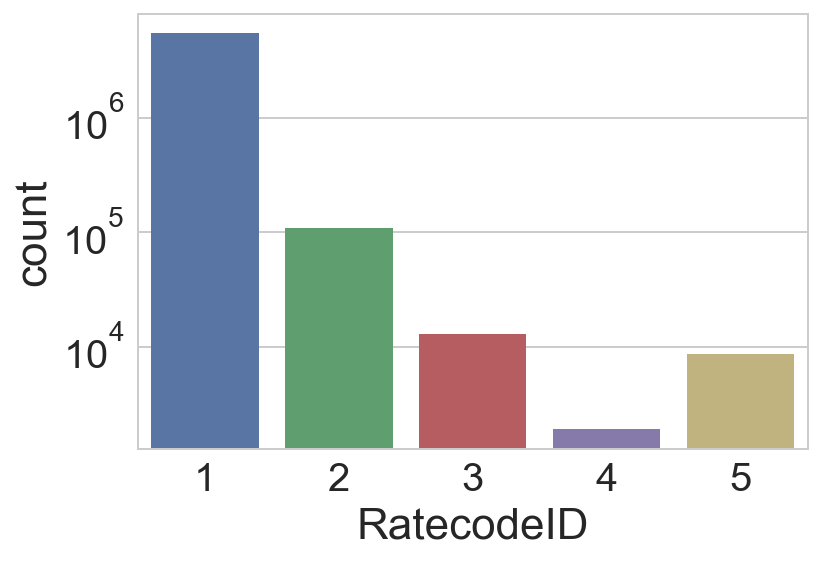

In [12]:
g = sns.countplot(df.RatecodeID)
g.set_yscale('log')

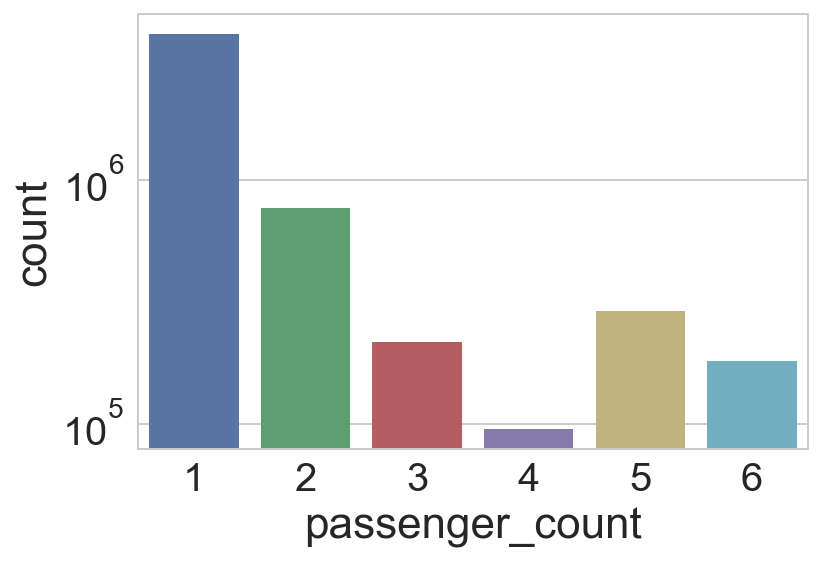

In [13]:
g = sns.countplot(df.passenger_count)
g.set_yscale('log')

In [14]:
# Coordinates variables.
min_x = -74.361107
min_y = 40.459518

max_x = -71.903083
max_y = 41.175342

step_x = 0.003205*11  # 3km meters approximately.
step_y = 0.002429*11  # 3km meters approximately.

# Number of maximum areas per axis in the 'area matrix'.
max_area_x = 766  # int((max_x - min_x) / step_x)
max_area_y = 294  # int((max_y - min_y) / step_y)

# Number of columns of the 'area matrix'.
num_columns = 767  # max_area_x + 1

# The area at the top right corner in the 'area matrix'.
max_area = 226264  # (max_area_y * num_columns) + max_area_x

# Minimum number of pickups or dropoffs per area.
min_area_number = 20


# Columns for creating the pickup and dropoff area attributes.
area_column_names = ['pickup_area', 'dropoff_area']
area_necesary_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


# Functions for calculating the pickup and dropoff areas in the 'area matrix'.

def get_1d_area(coor, min_coor, step_coor):
    return int((coor - min_coor) / step_coor)

def get_area(area_x, area_y, columns):
    return (area_y * columns) + area_x

def calculate_area(row):
    pickup_x = get_1d_area(row.pickup_longitude, min_x, step_x)
    pickup_y = get_1d_area(row.pickup_latitude, min_y, step_y)
    pickup_area = get_area(pickup_x, pickup_y, num_columns)
    
    dropoff_x = get_1d_area(row.dropoff_longitude, min_x, step_x)
    dropoff_y = get_1d_area(row.dropoff_latitude, min_y, step_y)
    dropoff_area = get_area(dropoff_x, dropoff_y, num_columns)
    
    return pd.Series({
        area_column_names[0]: pickup_area,
        area_column_names[1]: dropoff_area
    })

In [15]:
# This auxiliary function applies another one to every row in a DataFrame for creating new columns.
def iterate_and_apply(dataframe, function, necesary_columns):
    perform = True
    step = 100000
    start = 0
    to = step
    
    while perform:
        new_columns = dataframe[start:to][necesary_columns].apply(function, axis=1)
        if len(new_columns) == 0:
            perform = False
        else:
            dataframe.update(new_columns)
        new_columns = None
        start += step
        to += step
    
    return dataframe

In [16]:
biased_df1 = df[df.RatecodeID==1].sample(33049*3)
biased_df2 = df[df.RatecodeID==2].sample(4748*3)
biased_df3 = df[df.RatecodeID==3].sample(3003*3)
biased_df4 = df[df.RatecodeID==4].sample(620*3)
biased_df5 = df[df.RatecodeID==5].sample(1530*3)
biased_df = pd.concat([biased_df1,biased_df2,biased_df3,biased_df4,biased_df5],ignore_index=True)

In [17]:
for column in area_column_names:
    biased_df[column] = np.nan

biased_df = iterate_and_apply(biased_df, calculate_area, area_necesary_columns)

In [18]:
import folium
from folium.plugins import HeatMap
import os

In [37]:
import folium
from folium.plugins import HeatMap
import os

tipMapPickup = folium.Map([40.756716, -73.985368], tiles="CartoDB dark_matter", zoom_start=12)


#HeatMap(data[['pickup_latitude','pickup_longitude','tip_perc']].as_matrix().tolist()).add_to(m)
#folium.GeoJson(geo_json_data).add_to(m)
grouped = biased_df.groupby('pickup_area')
for name, group in grouped:
    radius = 1
    if group.tip_perc.mean()>.20:
        color="#FF0000"
    elif group.tip_perc.mean() > .175:
        color ="#f78b00"
    elif group.tip_perc.mean() > .15:
        color = "#fff300"
    elif group.tip_perc.mean() > .125:
        color = "#b8f300"
    elif group.tip_perc.mean() > .10:
        color = "#00f3d1"
    else:
        color="#007fdb"
    folium.CircleMarker(location=(group.dropoff_latitude.mean(),
                          group.dropoff_longitude.mean()),
                radius=radius,
                color=color,
                fill=True).add_to(tipMapPickup)
tipMapPickup.save('plots/tipMapPickup.html')

tipMapPickup


In [38]:
import folium
from folium.plugins import HeatMap
import os

tipMapDropoff = folium.Map([40.756716, -73.985368], tiles="CartoDB dark_matter", zoom_start=12)


#HeatMap(data[['pickup_latitude','pickup_longitude','tip_perc']].as_matrix().tolist()).add_to(m)
#folium.GeoJson(geo_json_data).add_to(m)
grouped = biased_df.groupby('dropoff_area')
for name, group in grouped:
    radius = 1
    if group.tip_perc.mean()>.20:
        color="#FF0000"
    elif group.tip_perc.mean() > .175:
        color ="#f78b00"
    elif group.tip_perc.mean() > .15:
        color = "#fff300"
    elif group.tip_perc.mean() > .125:
        color = "#b8f300"
    elif group.tip_perc.mean() > .10:
        color = "#00f3d1"
    else:
        color="#007fdb"
    folium.CircleMarker(location=(group.dropoff_latitude.mean(),
                          group.dropoff_longitude.mean()),
                radius=radius,
                color=color,
                fill=True).add_to(tipMapDropoff)

tipMapDropoff.save('plots/tipMapDropoff.html')
tipMapDropoff

In [34]:
import folium
from folium.plugins import HeatMap
import os

distMap = folium.Map([40.756716, -73.985368], tiles="CartoDB dark_matter", zoom_start=12)


#HeatMap(data[['pickup_latitude','pickup_longitude','tip_perc']].as_matrix().tolist()).add_to(m)
#folium.GeoJson(geo_json_data).add_to(m)
grouped = biased_df.groupby('dropoff_area')
for name, group in grouped:
    radius = 1
    if group.trip_distance.mean()> 30:
                color="#007fdb"

    elif group.trip_distance.mean() > 20:
        color = "#00f3d1"

    elif group.trip_distance.mean() > 15:
        color = "#b8f300"

    elif group.trip_distance.mean() > 10:
        color = "#fff300"
   

    elif group.trip_distance.mean() > 5:
        color ="#f78b00"
    else:
        color="#FF0000"
    folium.CircleMarker(location=(group.dropoff_latitude.mean(),
                          group.dropoff_longitude.mean()),
                radius=radius,
                color=color,
                fill=True).add_to(distMap)

distMap.save('plots/distMap.html')
distMap

In [33]:
import folium
from folium.plugins import HeatMap
import os

mtaMap = folium.Map([40.756716, -73.985368], tiles="CartoDB dark_matter", zoom_start=12)


#HeatMap(data[['pickup_latitude','pickup_longitude','tip_perc']].as_matrix().tolist()).add_to(m)
#folium.GeoJson(geo_json_data).add_to(m)
grouped = biased_df.groupby('dropoff_area')
for name, group in grouped:
    radius = 1
    if group.mta_tax.mean()>.25:
        color="#FF0000"
    else:
        color="#007fdb"
    folium.CircleMarker(location=(group.dropoff_latitude.mean(),
                          group.dropoff_longitude.mean()),
                radius=radius,
                color=color,
                fill=True).add_to(mtaMap)
mtaMap.save('plots/mtaMap.html')
mtaMap

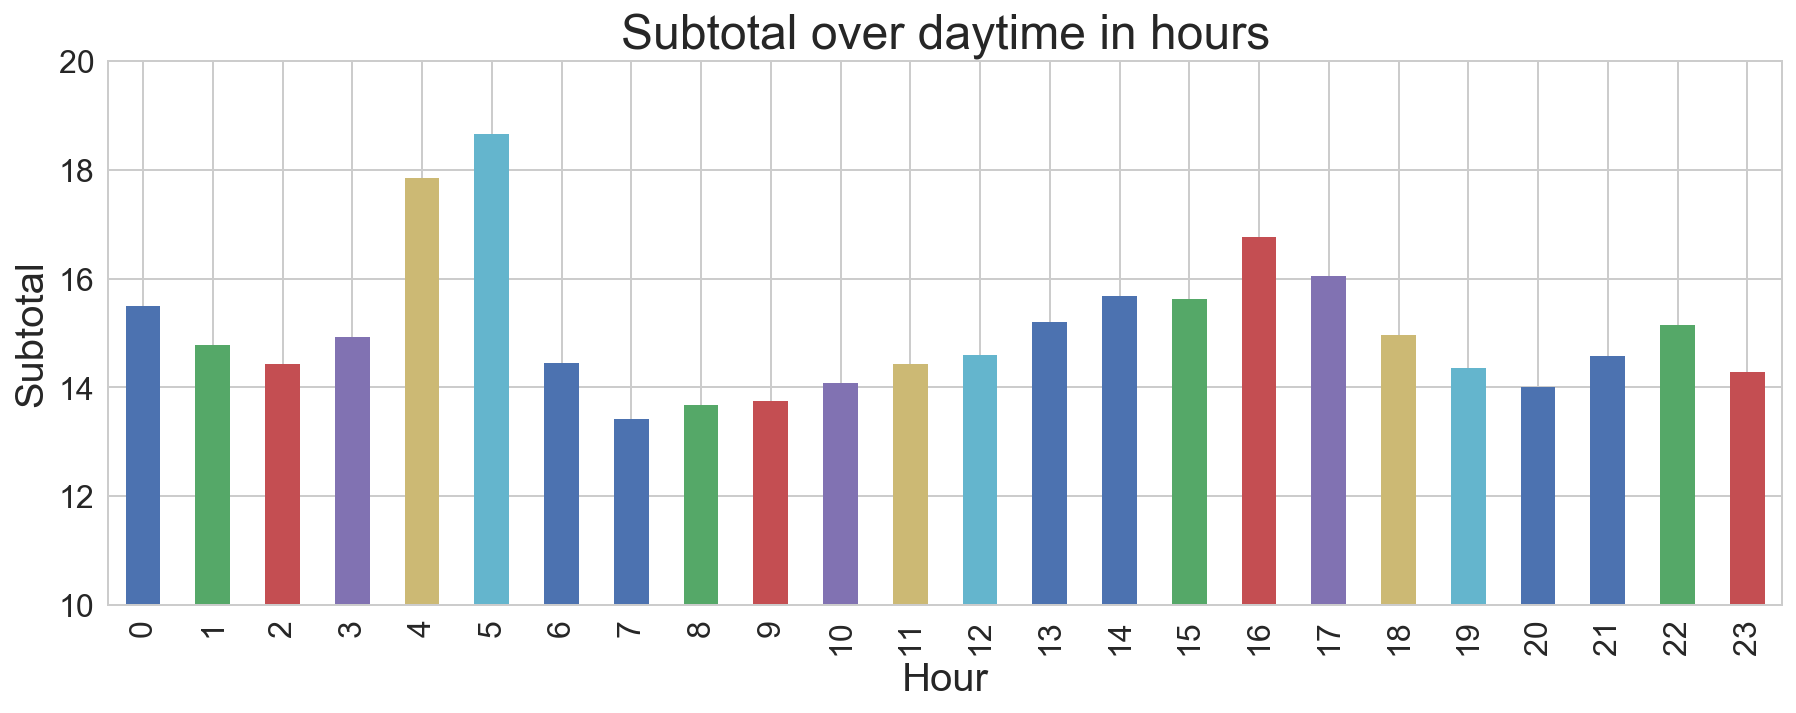

In [60]:
plt.figure(figsize=(16,9))

ax = df.groupby(['pickup_hour']).subtotal.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(10, 20)
plt.title('Subtotal over daytime in hours')
ax.set_xlabel('Hour', fontsize=20)
ax.set_ylabel('Subtotal', fontsize=20)
ax.tick_params(labelsize=16)

plt.savefig('plots/subtotalPercHour.pdf')
plt.savefig('plots/subtotalPercHour.png')

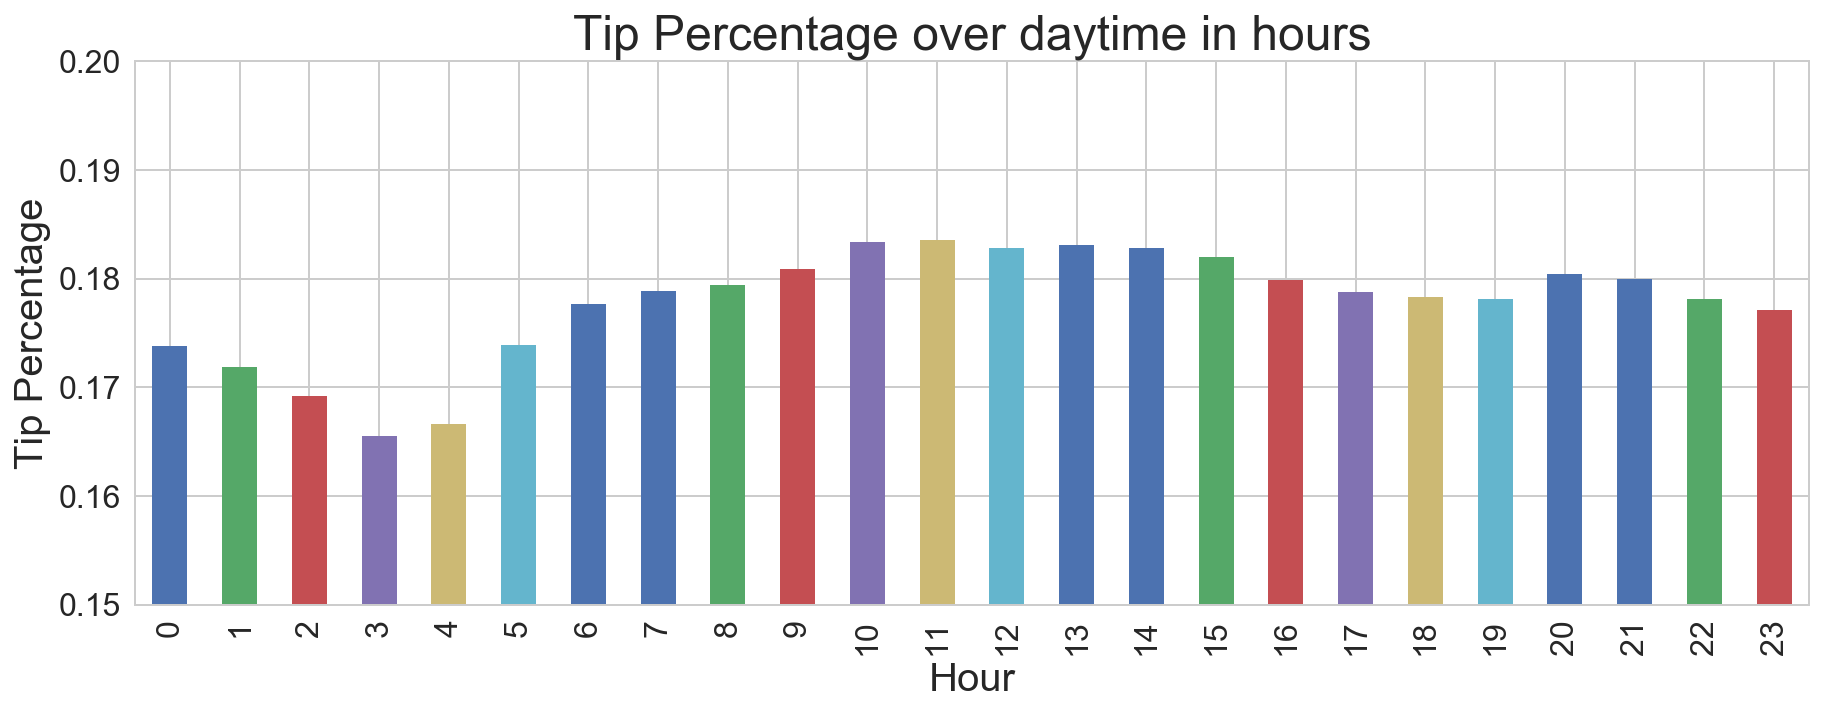

In [58]:
plt.figure(figsize=(16,9))

ax = df.groupby(['pickup_hour']).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
plt.title('Tip Percentage over daytime in hours')
ax.set_ylim(.15, .20)
ax.set_xlabel('Hour', fontsize=20)
ax.set_ylabel('Tip Percentage', fontsize=20)
ax.tick_params(labelsize=16)

plt.savefig('plots/tipPercHour.pdf')
plt.savefig('plots/tipPercHour.png')

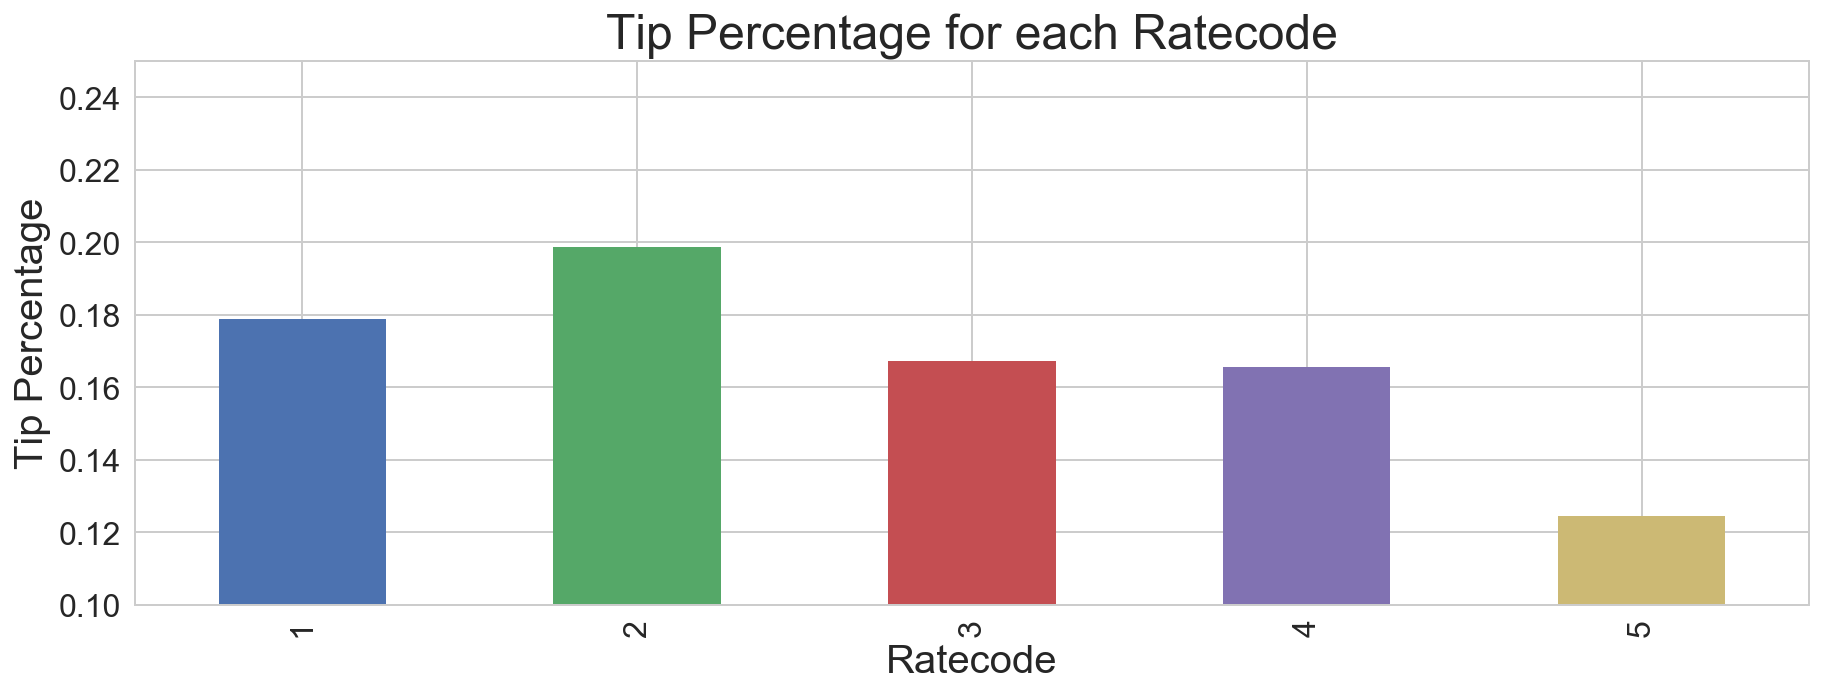

In [59]:
plt.figure(figsize=(16,9))

ax = df.groupby(['RatecodeID']).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
plt.title('Tip Percentage for each Ratecode')
ax.set_ylim(.10, .25)
ax.set_xlabel('Ratecode', fontsize=20)
ax.set_ylabel('Tip Percentage', fontsize=20)
ax.tick_params(labelsize=16)

plt.savefig('plots/tipPercRatecode.pdf')
plt.savefig('plots/tipPercRatecode.png')

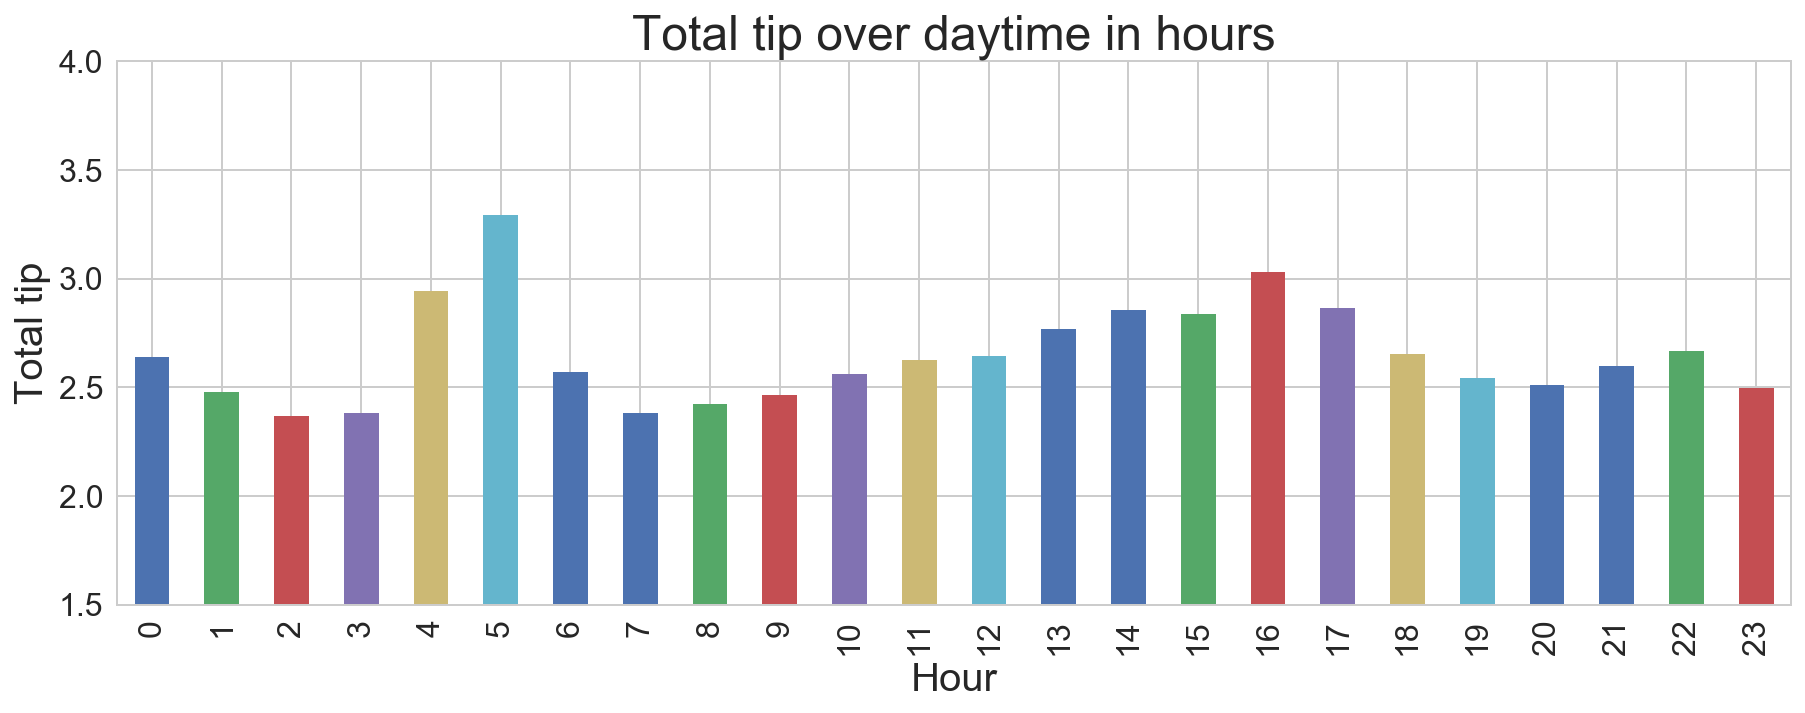

In [61]:
plt.figure(figsize=(16,9))

ax = df.groupby(['pickup_hour']).tip_amount.mean().plot(kind='bar', figsize=(15, 5))
plt.title('Total tip over daytime in hours')
ax.set_ylim(1.5, 4)
ax.set_xlabel('Hour', fontsize=20)
ax.set_ylabel('Total tip', fontsize=20)
ax.tick_params(labelsize=16)

plt.savefig('plots/tipTotalHour.pdf')
plt.savefig('plots/tipTotalHour.png')

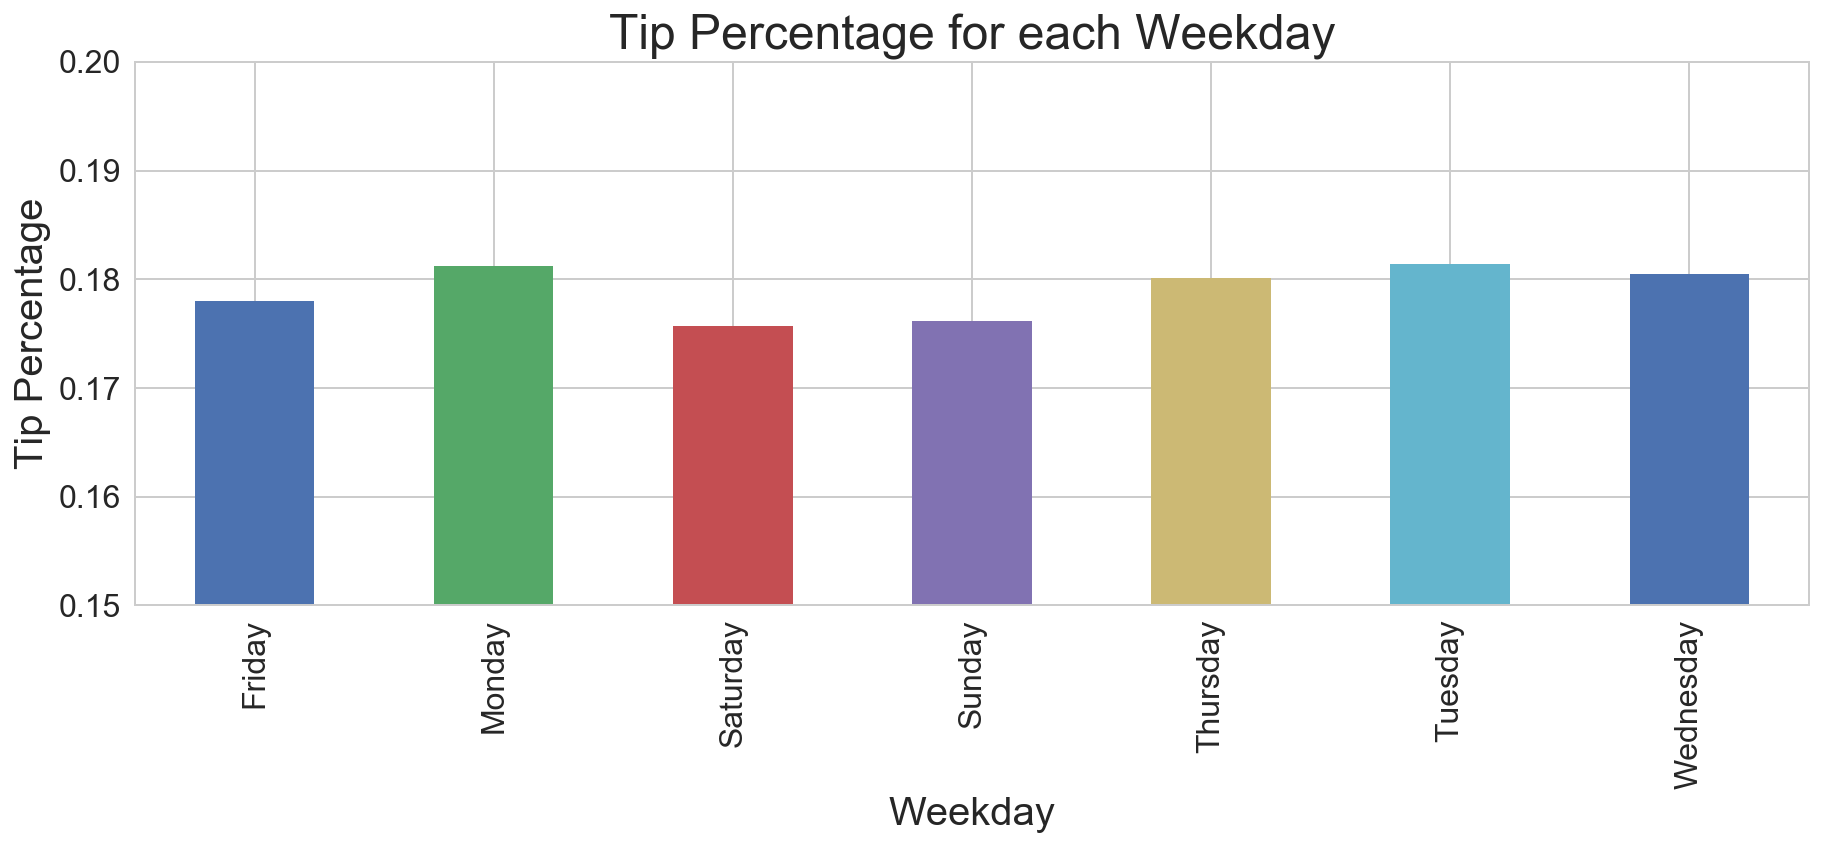

In [62]:
plt.figure(figsize=(16,9))

ax = df.groupby(['day']).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.15, .20)
plt.title('Tip Percentage for each Weekday')
ax.set_xlabel('Weekday', fontsize=20)
ax.set_ylabel('Tip Percentage', fontsize=20)
ax.tick_params(labelsize=16)

plt.savefig('plots/tipPercDay.pdf')
plt.savefig('plots/tipPercDay.png')

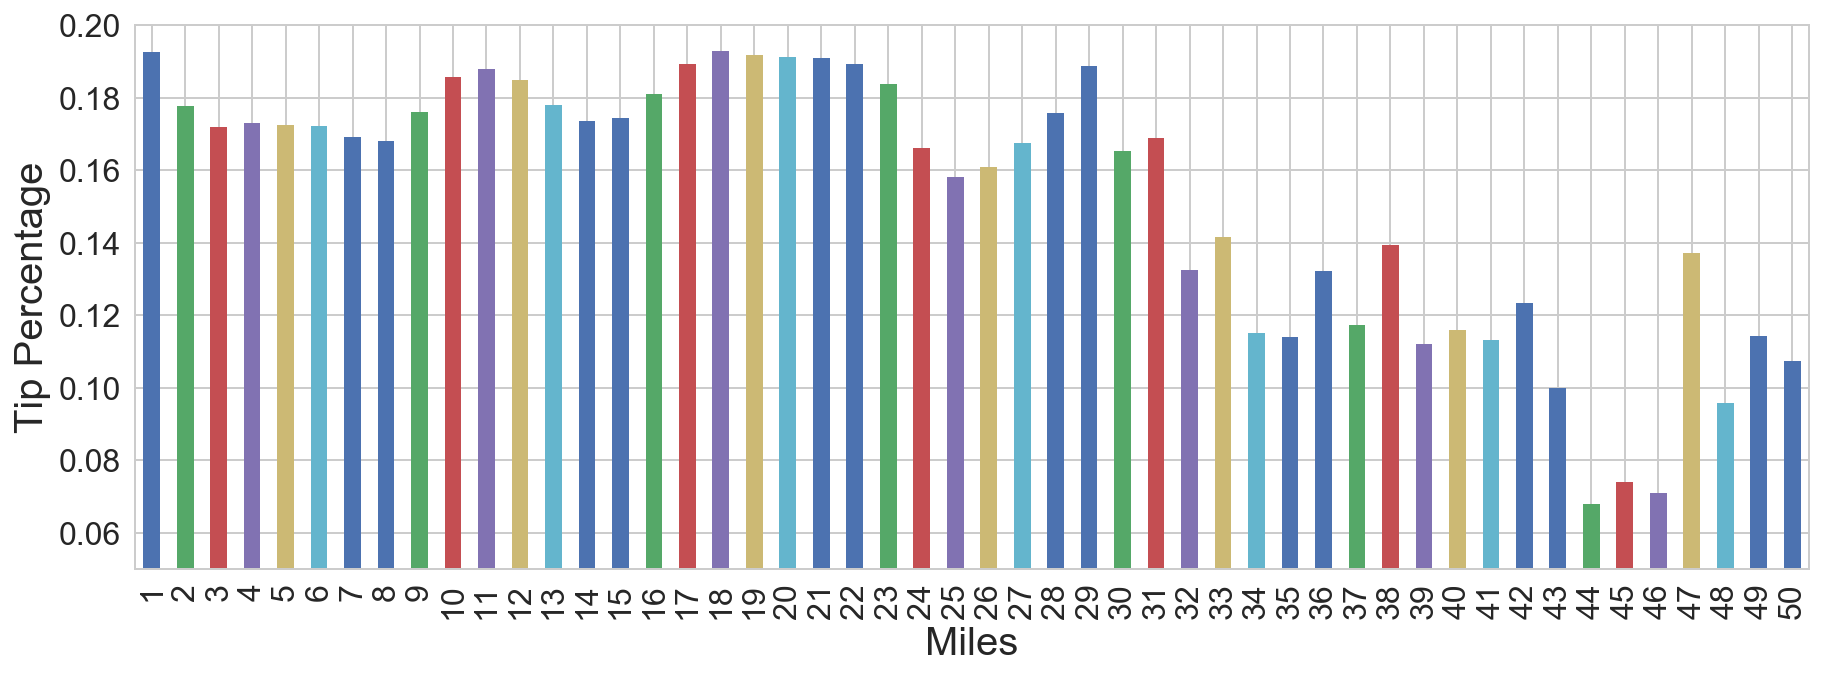

In [64]:
bins =  np.arange(0,50,1)
#bins = [0, 1, 5, 10, 25, 50, 100]
plt.figure(figsize=(16,9))

ind = np.digitize(df['trip_distance'],bins)

ax = df.groupby(ind).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.05, .20)
ax.set_xlabel('Miles', fontsize=20)
ax.set_ylabel('Tip Percentage', fontsize=20)
ax.tick_params(labelsize=16)

plt.savefig('plots/tipPercMiles.pdf')
plt.savefig('plots/tipPercMiles.png')

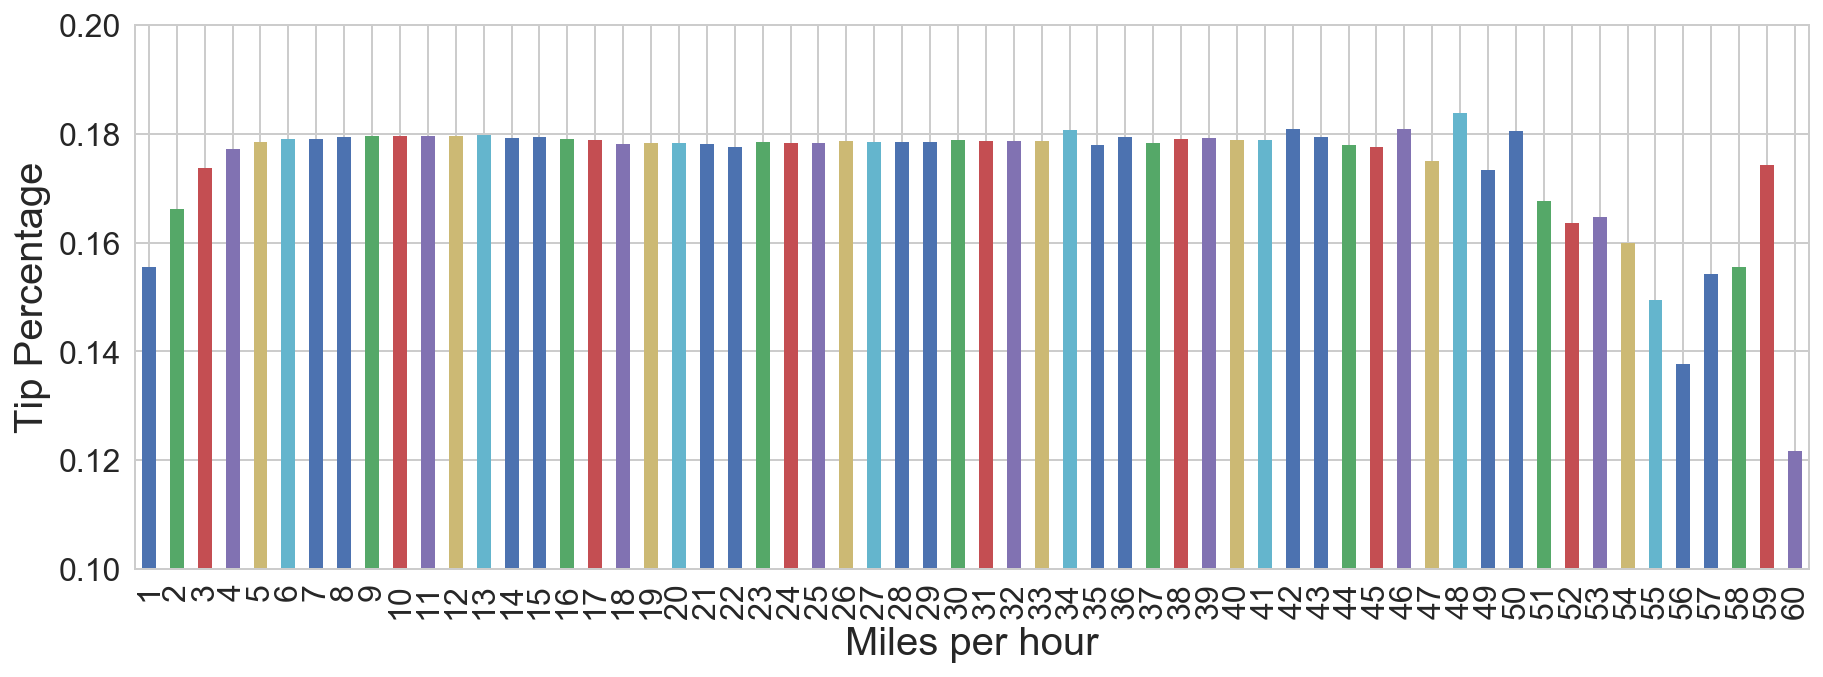

In [65]:
bins =  np.arange(0,60,1)
#bins = [0, 1, 5, 10, 25, 50, 100]
plt.figure(figsize=(16,9))

ind = np.digitize(df['avg_speed'],bins)

ax = df.groupby(ind).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.1, .20)
ax.set_xlabel('Miles per hour', fontsize=20)
ax.set_ylabel('Tip Percentage', fontsize=20)
ax.tick_params(labelsize=16)

plt.savefig('plots/tipPercMph.pdf')
plt.savefig('plots/tipPercMph.png')

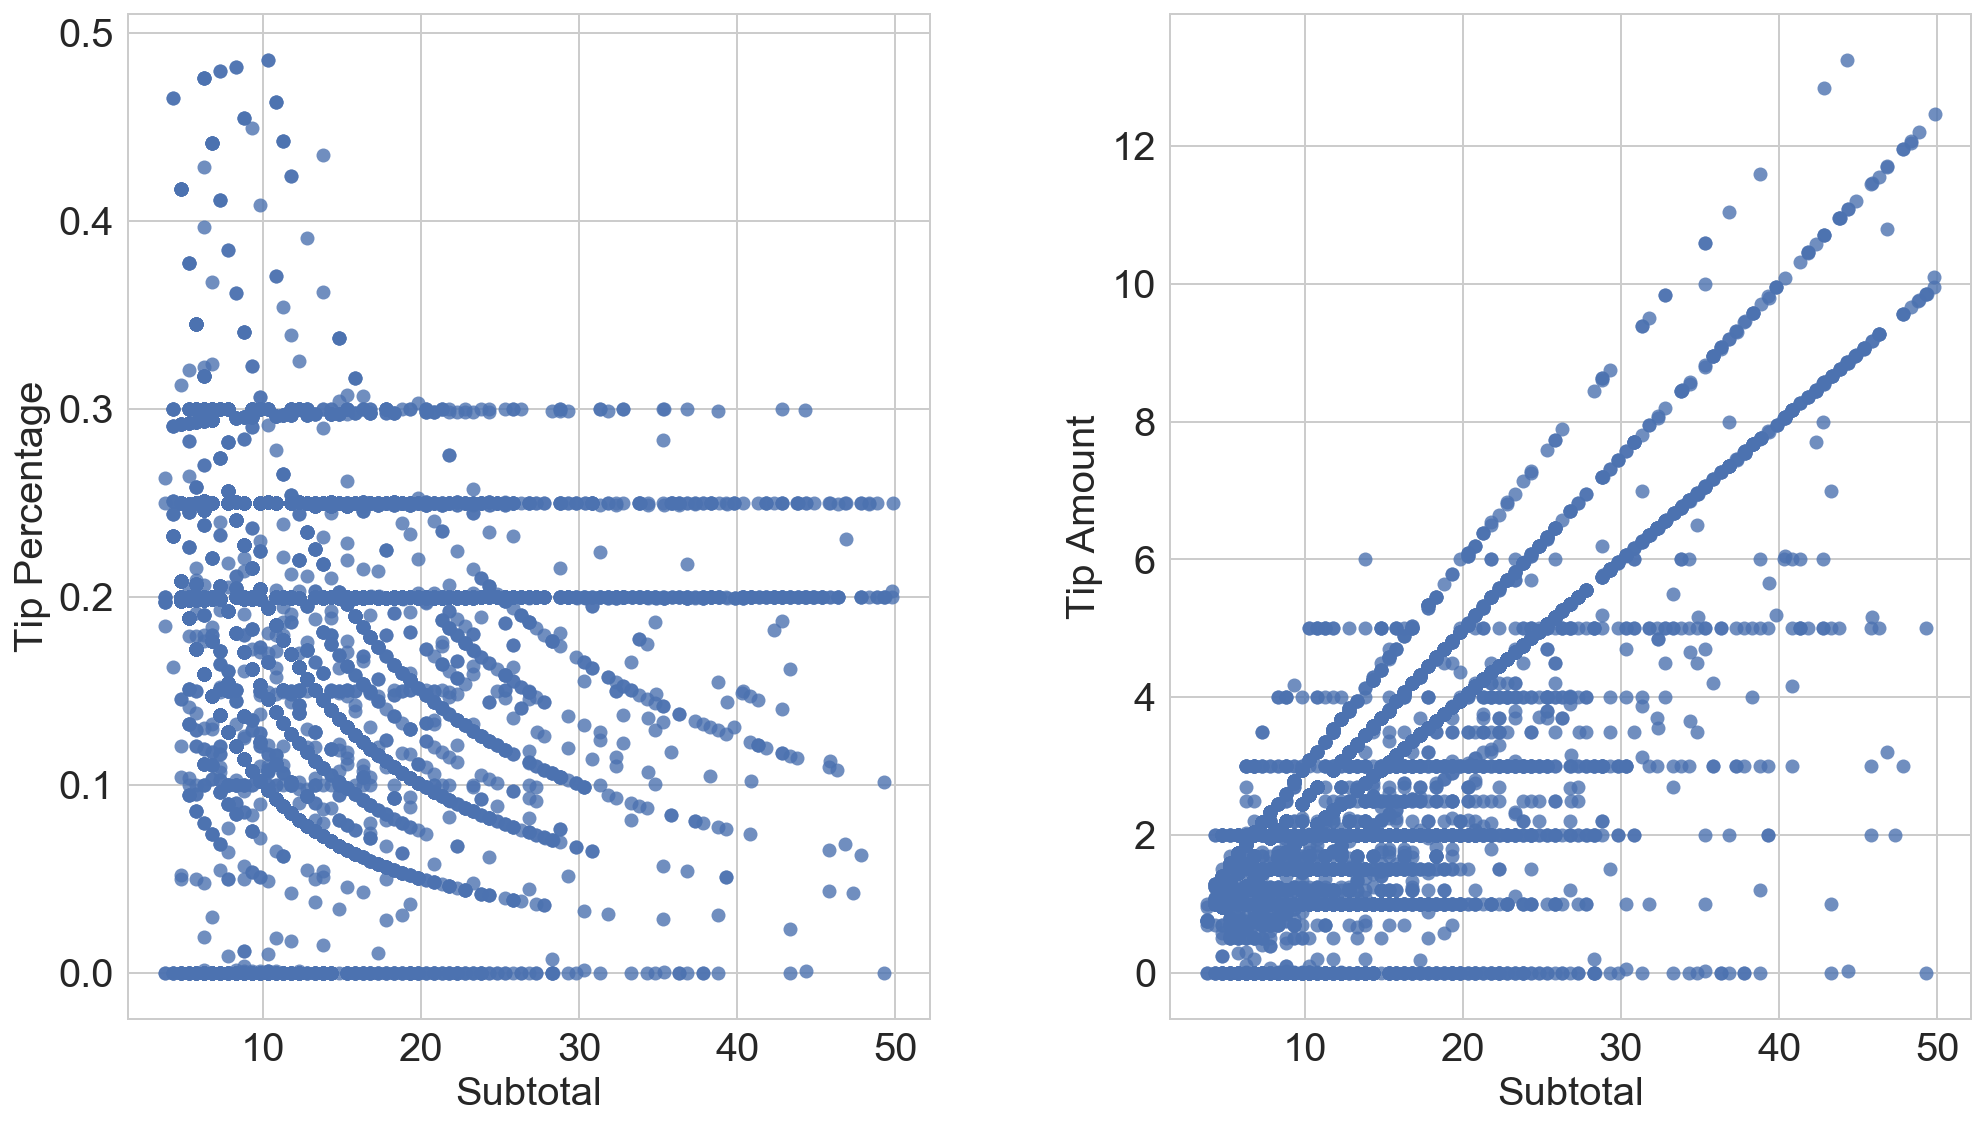

In [91]:
plt.figure(figsize=(16,9))
sample = df[df.subtotal < 50].sample(10000)
plt.subplot(1,2,1)
ax = sns.regplot(y='tip_perc',x='subtotal',fit_reg=False,data=sample)
ax.set_xlabel('Subtotal', fontsize=20)
ax.set_ylabel('Tip Percentage', fontsize=20)

plt.subplot(1,2,2)

ax = sns.regplot(y='tip_amount',x='subtotal',fit_reg=False,data=sample)
ax.set_xlabel('Subtotal', fontsize=20)
ax.set_ylabel('Tip Amount', fontsize=20)
plt.subplots_adjust(left=0.1, wspace=0.3, hspace=0.5, top=.9)

plt.savefig('plots/tipSubtotalReg.pdf')
plt.savefig('plots/tipSubtotalReg.png')

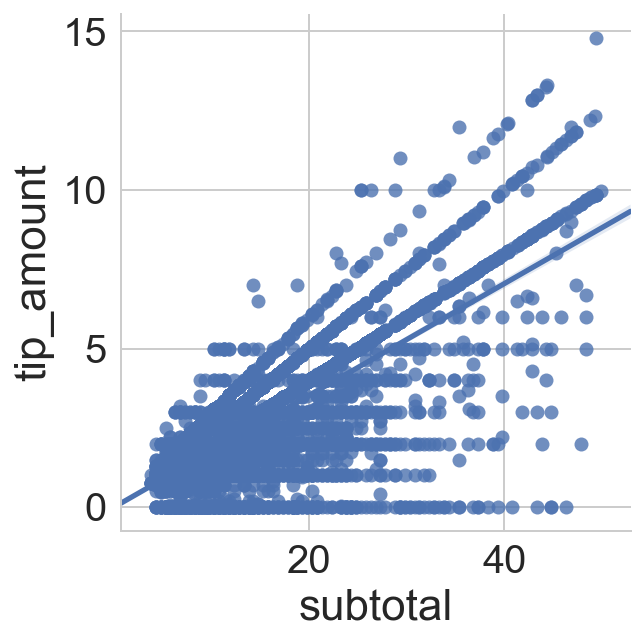

In [84]:
plt.figure(figsize=(16,9))
sns.regplot(y='tip_amount',x='subtotal',data=df[df.subtotal < 50].sample(10000))
plt.savefig('plots/tipTotalSubtotalReg.pdf')
plt.savefig('plots/tipTotalSubtotalReg.png')

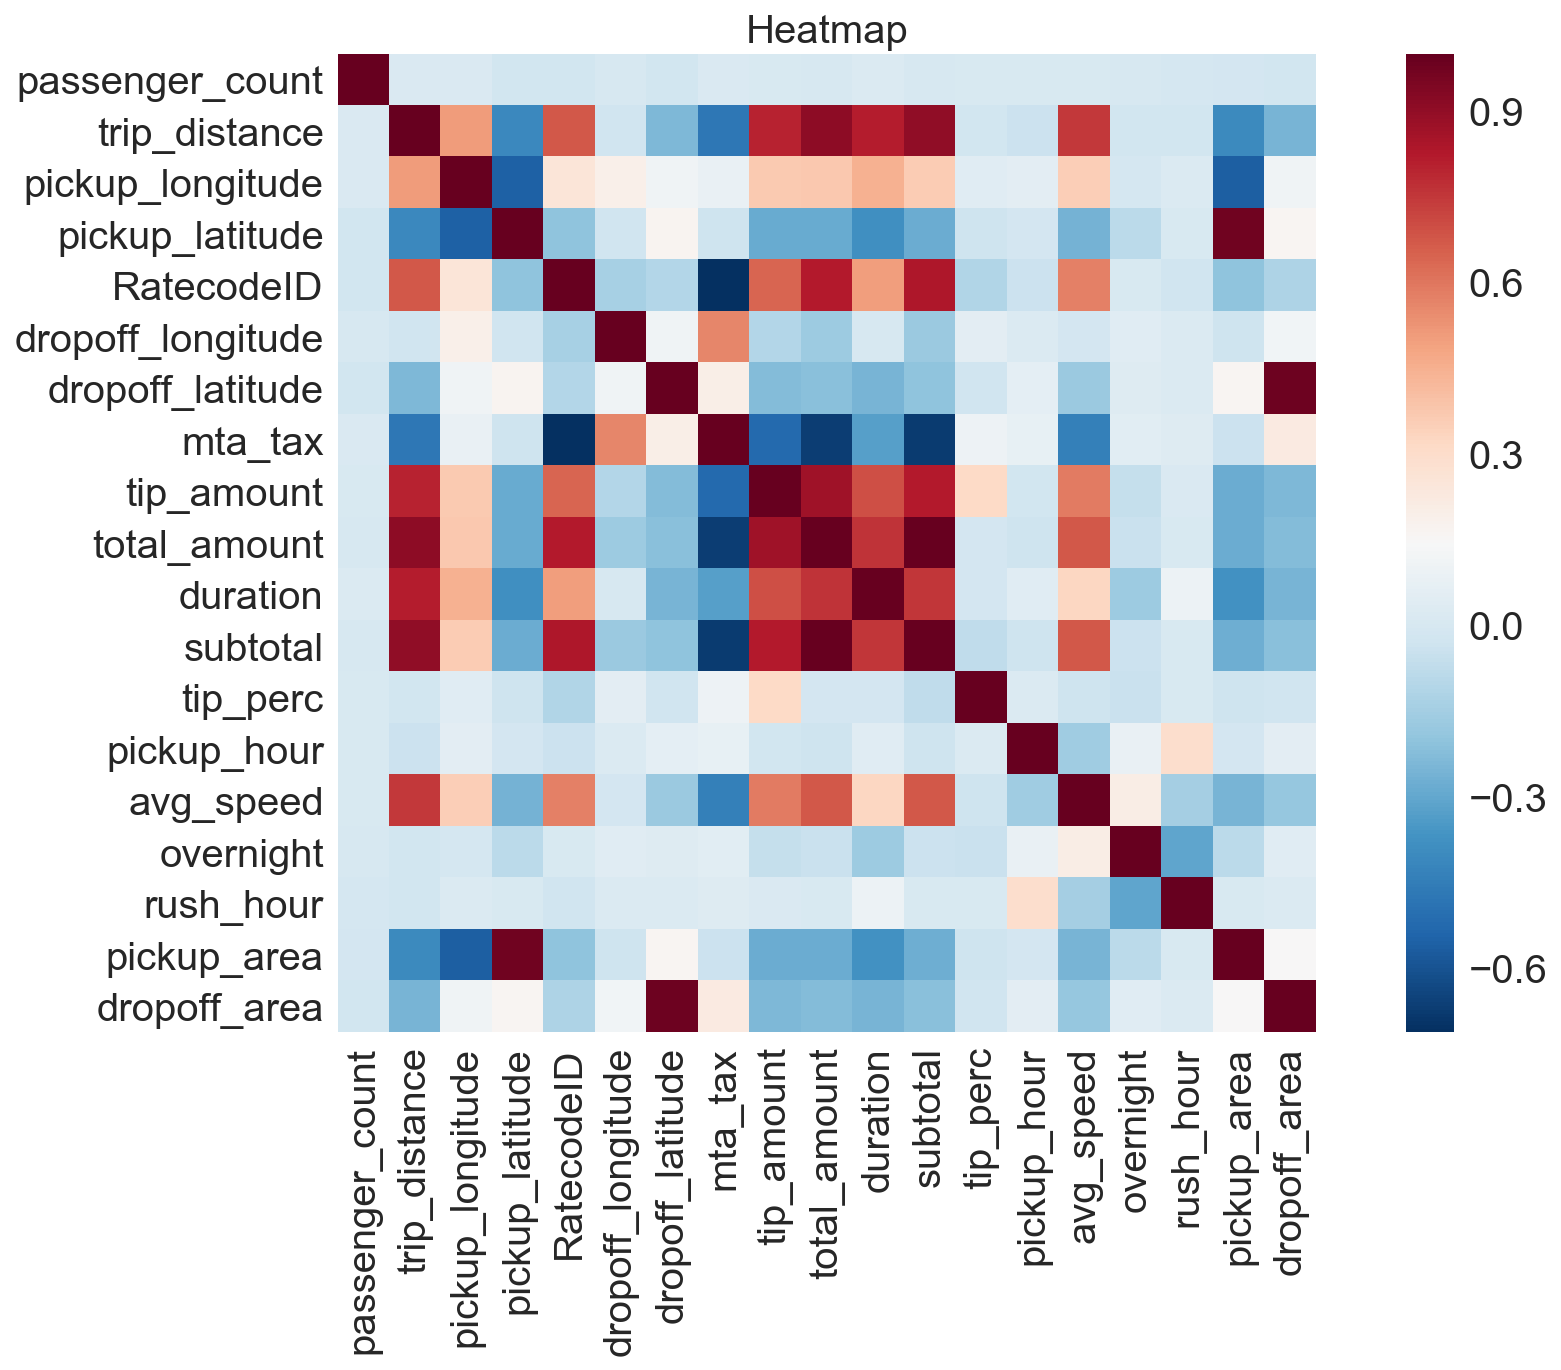

In [93]:
corr = biased_df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1).corr()

plt.figure(figsize=(16,9))

plt.title("Heatmap",fontsize=20)
sns.heatmap(corr, cmap="RdBu_r", square=True)

In [95]:
df.groupby(['RatecodeID']).tip_perc.mean()

RatecodeID
1    0.178851
2    0.198726
3    0.167352
4    0.165714
5    0.124545
Name: tip_perc, dtype: float64

In [96]:
biased_df[biased_df.avg_speed > 50].count()

tpep_pickup_datetime     224
tpep_dropoff_datetime    224
passenger_count          224
trip_distance            224
pickup_longitude         224
pickup_latitude          224
RatecodeID               224
dropoff_longitude        224
dropoff_latitude         224
mta_tax                  224
tip_amount               224
total_amount             224
pickup_time              224
dropoff_time             224
duration                 224
subtotal                 224
tip_perc                 224
pickup_hour              224
avg_speed                224
overnight                224
day                      224
rush_hour                224
pickup_area              224
dropoff_area             224
dtype: int64

### Prepare model data

Figures show that trip dist > 30 and speed > 40 are very strange and may be outliers.

In [98]:
df = df.drop(df[(df.trip_distance > 30 )].index)
df = df.drop(df[(df.avg_speed > 40)].index)

In [99]:
df.RatecodeID.value_counts()

1    5397262
2     101974
3      11586
5       6952
4       1683
Name: RatecodeID, dtype: int64

In [100]:
biased_df1 = df[df.RatecodeID==1].sample(33049*2)
biased_df2 = df[df.RatecodeID==2].sample(4748*2)
biased_df3 = df[df.RatecodeID==3].sample(3003*2)
biased_df4 = df[df.RatecodeID==4].sample(620*2)
biased_df5 = df[df.RatecodeID==5].sample(1530*2)
biased_df = pd.concat([biased_df1,biased_df2,biased_df3,biased_df4,biased_df5],ignore_index=True)

In [104]:
for column in area_column_names:
    biased_df[column] = np.nan

biased_df = iterate_and_apply(biased_df, calculate_area, area_necesary_columns)

In [ ]:
biased_df[biased_df.]

In [105]:
biased_df['pickup_hour'] = biased_df.pickup_hour.astype('category')
biased_df['RatecodeID'] = biased_df.RatecodeID.astype('category')
biased_df['passenger_count'] = biased_df.passenger_count.astype('category')
biased_df['pickup_area'] = biased_df.pickup_area.astype('category')
biased_df['dropoff_area'] = biased_df.dropoff_area.astype('category')
biased_df['weekday'] = pd.to_datetime(biased_df.tpep_pickup_datetime).dt.weekday.astype('category')

In [106]:
biased_df.RatecodeID.value_counts()

1    66098
2     9496
3     6006
5     3060
4     1240
Name: RatecodeID, dtype: int64

In [107]:
biased_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85900 entries, 0 to 85899
Data columns (total 25 columns):
tpep_pickup_datetime     85900 non-null object
tpep_dropoff_datetime    85900 non-null object
passenger_count          85900 non-null category
trip_distance            85900 non-null float64
pickup_longitude         85900 non-null float64
pickup_latitude          85900 non-null float64
RatecodeID               85900 non-null category
dropoff_longitude        85900 non-null float64
dropoff_latitude         85900 non-null float64
mta_tax                  85900 non-null float64
tip_amount               85900 non-null float64
total_amount             85900 non-null float64
pickup_time              85900 non-null object
dropoff_time             85900 non-null object
duration                 85900 non-null float64
subtotal                 85900 non-null float64
tip_perc                 85900 non-null float64
pickup_hour              85900 non-null category
avg_speed                859

## Baseline

Calulcate the avg

Use as prediction baseline

In [175]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test \
    = train_test_split(biased_df[['subtotal','tip_perc','RatecodeID']]\
                     ,biased_df['tip_amount'], test_size=0.25, random_state=1337)

In [176]:
avg = (df.tip_perc.mean())

In [177]:
avg

0.17913732891856568

In [178]:
baseline = (X_test.subtotal*avg).values

In [179]:
err = pd.DataFrame(y_test-baseline)
err.describe()

tip_amount
count  21475.000000
mean      -0.123059
std        2.789500
min      -43.842070
25%       -0.397271
50%        0.225317
75%        0.781866
max       25.525704

In [180]:
mean_absolute_error(baseline,y_test)

1.3866468042032647

In [181]:
df.RatecodeID = df.RatecodeID.astype('int32')

In [182]:
avg = (df.groupby(['RatecodeID']).tip_perc.mean())

In [183]:
avg

RatecodeID
1    0.178862
2    0.198845
3    0.167458
4    0.167601
5    0.126190
Name: tip_perc, dtype: float64

In [184]:
avg.loc[4]

0.1676005623295438

In [185]:
conditions = [ \
    (X_test['RatecodeID'] == 1), \
    (X_test['RatecodeID'] == 2), \
    (X_test['RatecodeID'] == 3), \
    (X_test['RatecodeID'] == 4),
    (X_test['RatecodeID'] == 5)\
]
choices = [avg.loc[1],  avg.loc[2], avg.loc[3], avg.loc[4], avg.loc[5]]
baseline_perc = np.select(conditions, choices, default=0)
baseline = baseline_perc*X_test.subtotal

In [186]:
mean_absolute_error(y_test,baseline)

1.3073109116082486

## Prepare train / test set

In [195]:
df_train = biased_df[['RatecodeID','pickup_hour','trip_distance',\
                   'subtotal','avg_speed','pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude',\
                   'weekday']]
#df_train = pd.get_dummies(df_train, columns = ['pickup_area','dropoff_area','weekday','pickup_hour','RatecodeID'] )

In [196]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train,biased_df['tip_amount'], test_size=0.3, random_state=1337)

In [162]:
y_train.head()

17090     2.16
83309     0.00
51857     1.95
76913    23.06
754       2.00
Name: tip_amount, dtype: float64

In [163]:
df.tip_amount.describe()

count    5.519457e+06
mean     2.606497e+00
std      2.359607e+00
min      0.000000e+00
25%      1.200000e+00
50%      2.000000e+00
75%      3.060000e+00
max      9.505000e+01
Name: tip_amount, dtype: float64

## Linear Regression

In [164]:
df_train2 = biased_df[['RatecodeID','pickup_hour','trip_distance','subtotal','avg_speed','weekday',\
                      'pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude']]
df_train2 = pd.get_dummies(df_train2, columns = ['weekday','pickup_hour','RatecodeID'] )

In [165]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_train2,biased_df['tip_perc'], test_size=0.3, random_state=1337)

In [166]:
df_train2.columns

Index(['trip_distance', 'subtotal', 'avg_speed', 'pickup_latitude',
       'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'pickup_hour_0', 'pickup_hour_1',
       'pickup_hour_2', 'pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5',
       'pickup_hour_6', 'pickup_hour_7', 'pickup_hour_8', 'pickup_hour_9',
       'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12', 'pickup_hour_13',
       'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16', 'pickup_hour_17',
       'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20', 'pickup_hour_21',
       'pickup_hour_22', 'pickup_hour_23', 'RatecodeID_1', 'RatecodeID_2',
       'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5'],
      dtype='object')

In [167]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train2,y_train2)

pred = regr.predict(X_test2)

In [168]:
pred

array([0.1823861 , 0.17888986, 0.17638468, ..., 0.17249981, 0.19946366,
       0.18295679])

In [169]:
X_train2.columns

Index(['trip_distance', 'subtotal', 'avg_speed', 'pickup_latitude',
       'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'pickup_hour_0', 'pickup_hour_1',
       'pickup_hour_2', 'pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5',
       'pickup_hour_6', 'pickup_hour_7', 'pickup_hour_8', 'pickup_hour_9',
       'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12', 'pickup_hour_13',
       'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16', 'pickup_hour_17',
       'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20', 'pickup_hour_21',
       'pickup_hour_22', 'pickup_hour_23', 'RatecodeID_1', 'RatecodeID_2',
       'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5'],
      dtype='object')

In [170]:
# The coefficients
print ("intercept:", regr.intercept_)
coefs = regr.coef_[:] #copy by slicing
coefs[abs(coefs)<0.001] =0
pd.DataFrame({"Features" : X_train2.columns,"estimatedCoefficients": coefs})

intercept: -1.6314526996414014


Features  estimatedCoefficients
0       trip_distance               0.000000
1            subtotal               0.000000
2           avg_speed               0.000000
3     pickup_latitude               0.021433
4    dropoff_latitude              -0.009780
5    pickup_longitude              -0.001375
6   dropoff_longitude              -0.016634
7           weekday_0               0.000000
8           weekday_1               0.001236
9           weekday_2               0.002656
10          weekday_3               0.002604
11          weekday_4               0.000000
12          weekday_5              -0.003060
13          weekday_6              -0.004520
14      pickup_hour_0              -0.003652
15      pickup_hour_1              -0.004852
16      pickup_hour_2              -0.013929
17      pickup_hour_3              -0.011624
18      pickup_hour_4              -0.015018
19      pickup_hour_5              -0.003163
20      pickup_hour_6               0.000000
21      pickup_hour_7               0.001573
22      pickup_hour_8               0.001159
23      pickup_hour_9               0.004033
24     pickup_hour_10               0.005756
25     pickup_hour_11               0.006592
26     pickup_hour_12               0.006177
27     pickup_hour_13               0.004227
28     pickup_hour_14               0.006006
29     pickup_hour_15               0.007131
30     pickup_hour_16               0.006320
31     pickup_hour_17               0.002724
32     pickup_hour_18               0.001454
33     pickup_hour_19               0.000000
34     pickup_hour_20               0.000000
35     pickup_hour_21               0.002068
36     pickup_hour_22              -0.001248
37     pickup_hour_23              -0.001337
38       RatecodeID_1               0.001830
39       RatecodeID_2               0.030700
40       RatecodeID_3              -0.001940
41       RatecodeID_4               0.000000
42       RatecodeID_5              -0.031178

In [171]:
pred_vals = (X_test.subtotal)*pred

In [172]:
err = y_test-pred_vals

In [173]:
mean_absolute_error(y_test,pred_vals)

1.322674442277589

## Random Forest

In [197]:
from sklearn.metrics import mean_absolute_error, r2_score

In [198]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=8,random_state=1337)

rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=1,
           oob_score=False, random_state=1337, verbose=0, warm_start=False)

In [199]:
rfr_pred = rfr.predict(X_test)

In [200]:
err = pd.DataFrame(y_test-rfr_pred)
err.describe()

tip_amount
count  25770.000000
mean       0.008700
std        2.785232
min      -33.393750
25%       -0.518438
50%        0.071250
75%        0.666250
max       35.462500

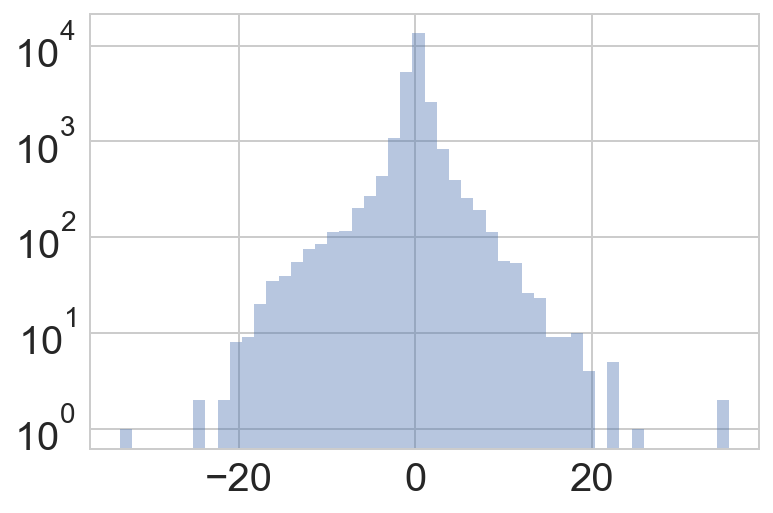

In [201]:
ax = sns.distplot(err,hist_kws={"log":True},kde=False);

In [202]:
# Feature importance# Feature 
pd.DataFrame({"Features" : X_train.columns,"estimatedCoefficients": rfr.feature_importances_})

Features  estimatedCoefficients
0         RatecodeID               0.008017
1        pickup_hour               0.022786
2      trip_distance               0.033814
3           subtotal               0.753853
4          avg_speed               0.034395
5    pickup_latitude               0.034083
6   dropoff_latitude               0.032582
7   pickup_longitude               0.032826
8  dropoff_longitude               0.034699
9            weekday               0.012946

In [203]:
df.tip_amount.max()

95.05

In [204]:
mean_absolute_error(y_test,rfr_pred)

1.418907450523865

### with Boosting

In [205]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor


from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

import lightgbm as lgbm

In [206]:
pipeline = make_pipeline(preprocessing.StandardScaler(),
                         RandomForestRegressor())
param_grid = { 'randomforestregressor__n_estimators': [16],
               'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
               'randomforestregressor__min_samples_split': [2, 5],
               }


#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=2231)
clf = GridSearchCV(pipeline, param_grid, n_jobs=-1,error_score='neg_mean_absolute_error')    
clf.fit(X_train, y_train)
#evaluateRF(clf,X_test,y_test)

GridSearchCV(cv=None, error_score='neg_mean_absolute_error',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestregressor__n_estimators': [16], 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Model Performance
Average Error: 1.3681 degrees.
R2 Score: 0.7205
MAE: 1.3681


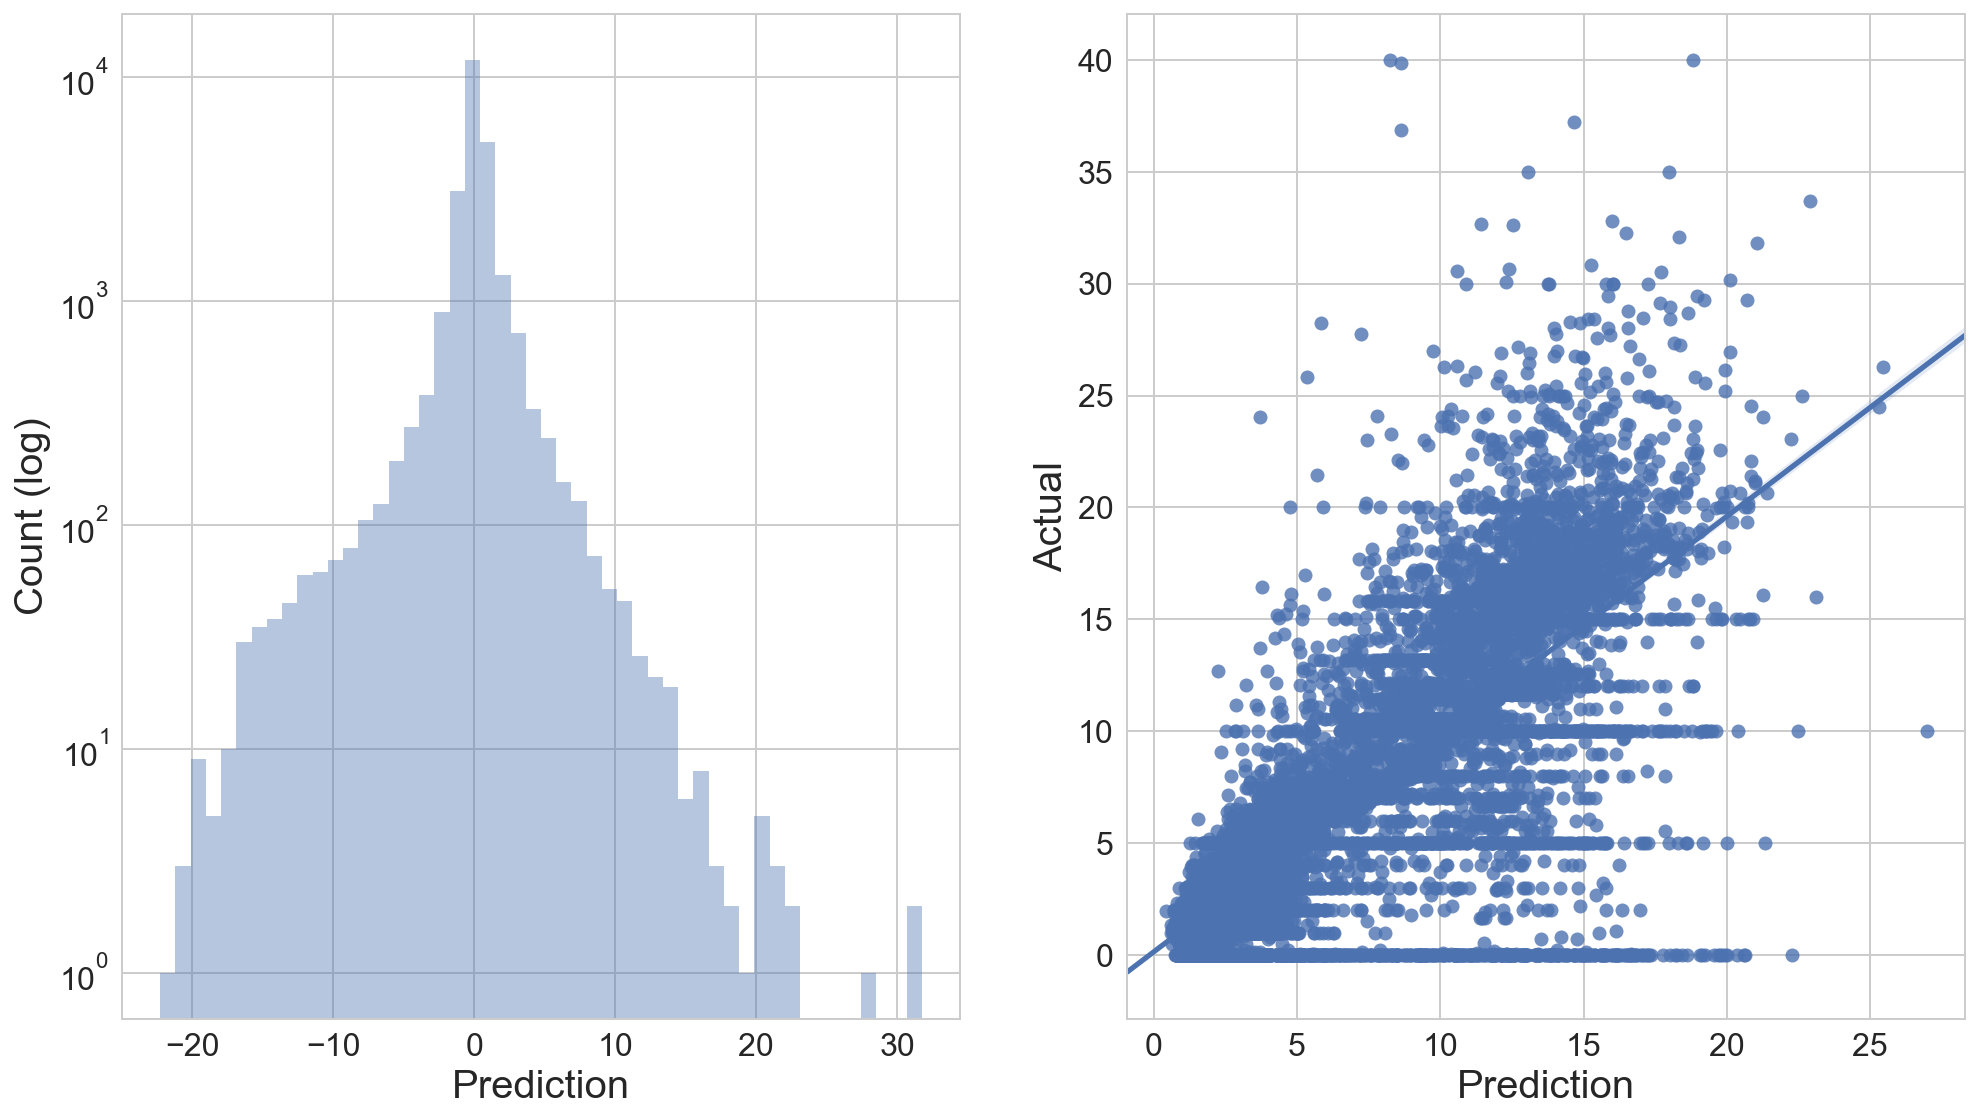

In [234]:
evaluateRF(clf,X_test,y_test,'RF_Tip_pred_boosted')

In [237]:
import lightgbm as lgb

# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [160,320]
}

gbm = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)


Best parameters found by grid search are: {'learning_rate': 0.01, 'n_estimators': 320}


Model Performance
Average Error: 1.3323 degrees.
R2 Score: 0.7362
MAE: 1.3323


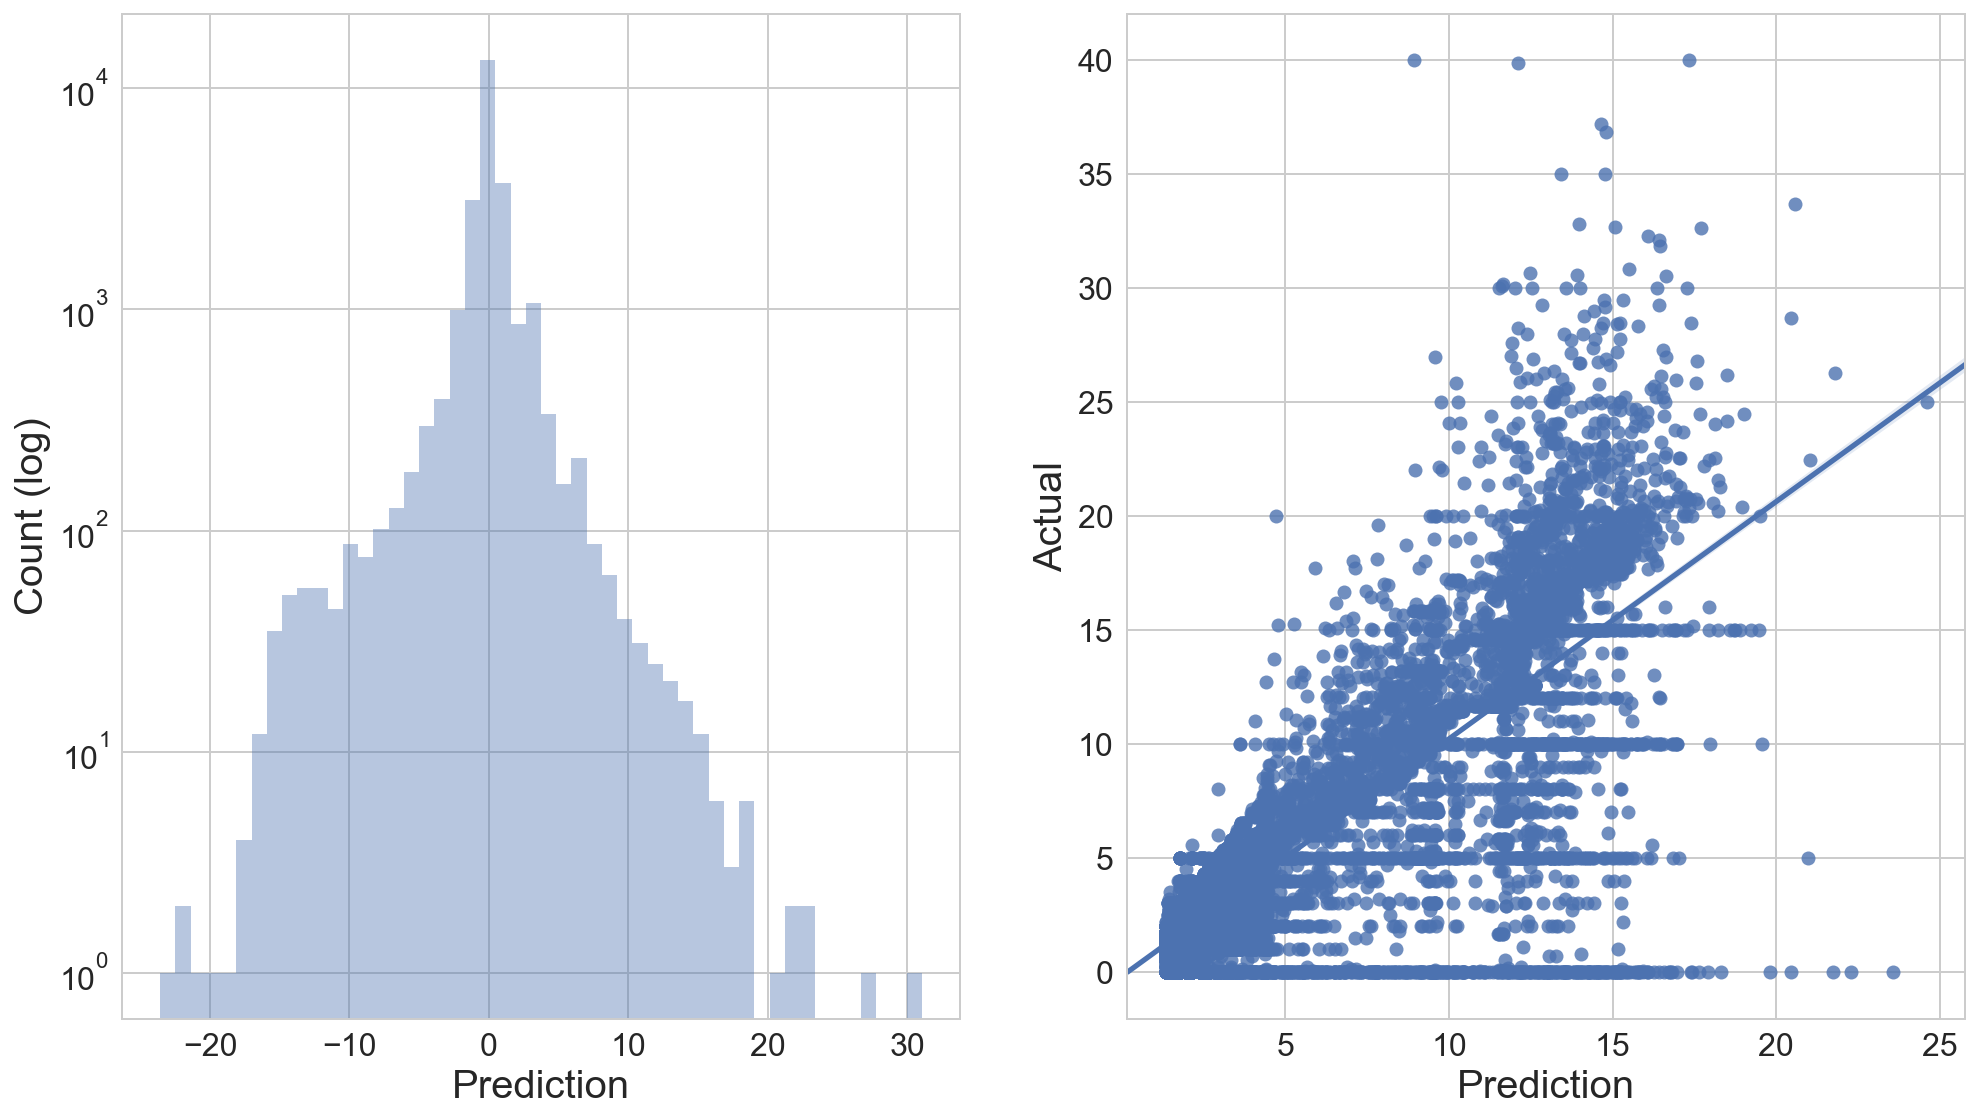

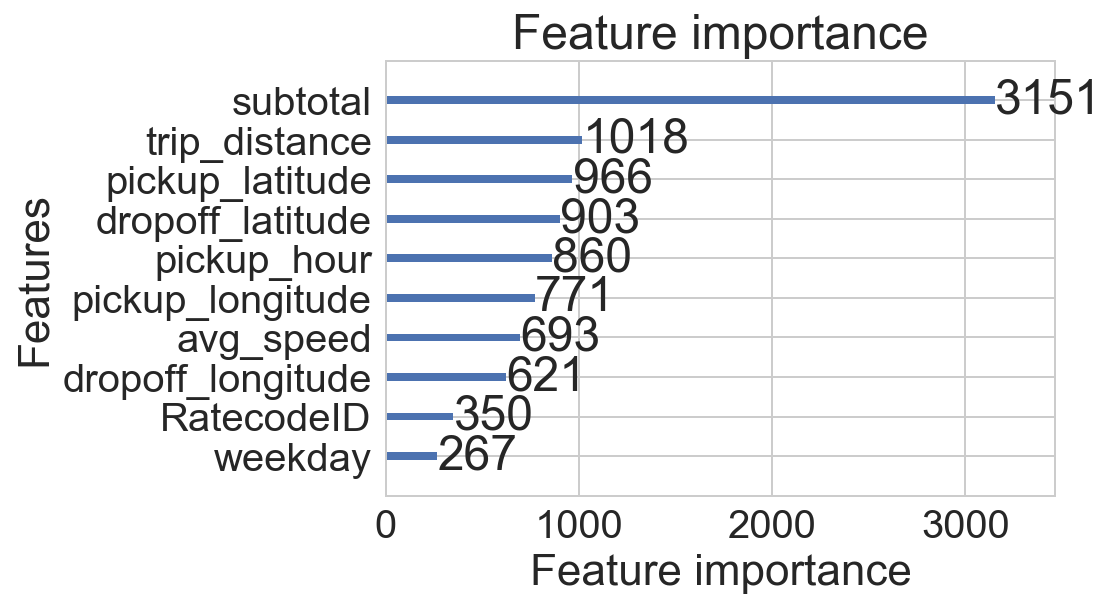

In [238]:
evaluateLGB(gbm, X_test,y_test, 'lgbm_tips_unboosted')

In [240]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['gdbt']
}

gbm2 = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')

gbm2.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm2.best_params_)

Best parameters found by grid search are: {'boosting': 'gdbt', 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 320, 'objective': 'mae'}


Model Performance
Average Error: 1.2979 degrees.
R2 Score: 0.7294
MAE: 1.2979


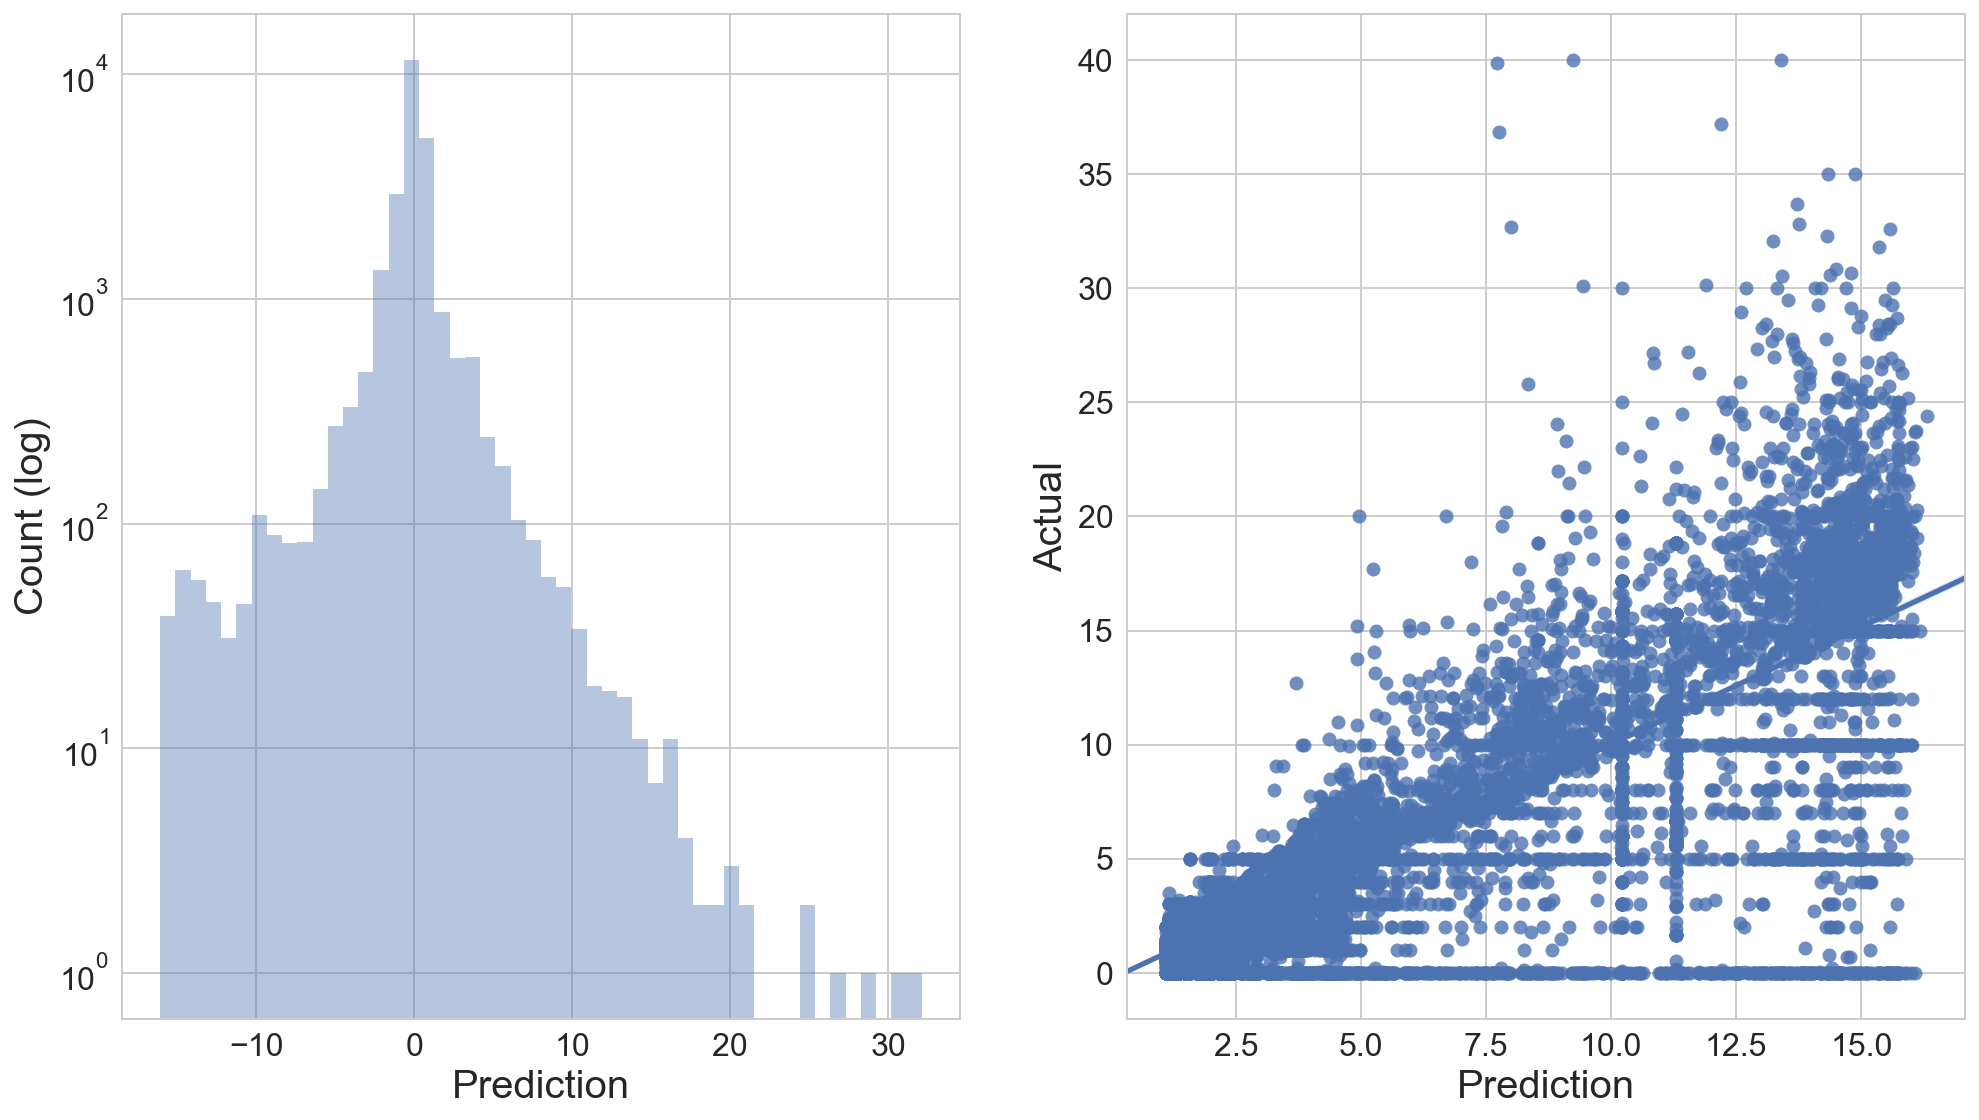

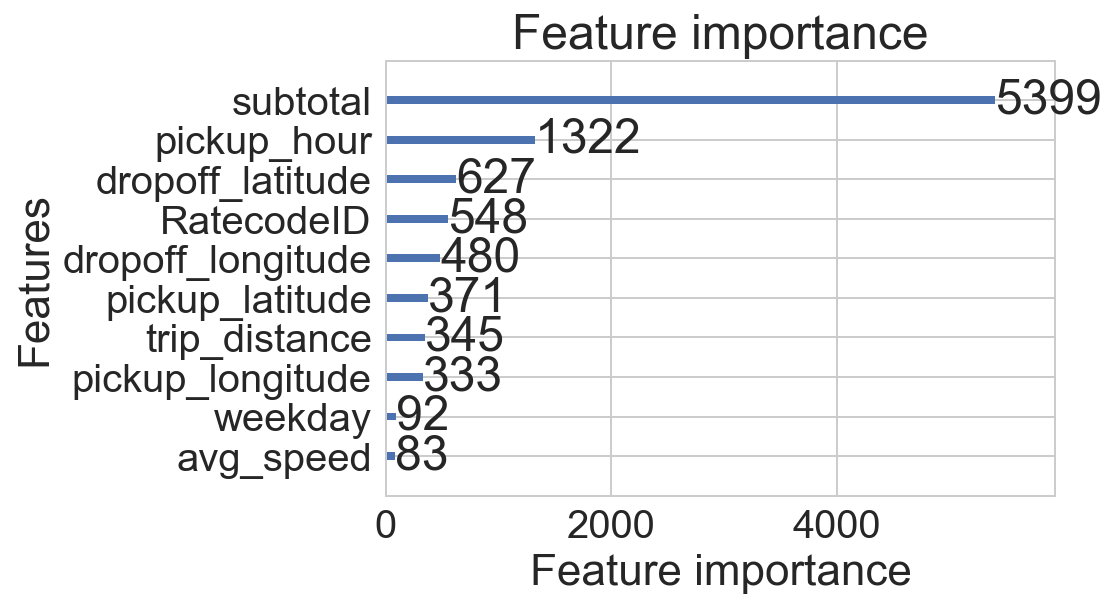

In [241]:
evaluateLGB(gbm2, X_test,y_test,'lgbm_tips_boosted1')

In [242]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['rf']
}

gbmRF = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')

gbmRF.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbmRF.best_params_)

Best parameters found by grid search are: {'boosting': 'rf', 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 320, 'objective': 'mae'}


In [243]:
print('Best parameters found by grid search are:', gbmRF.best_params_)

Best parameters found by grid search are: {'boosting': 'rf', 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 320, 'objective': 'mae'}


Model Performance
Average Error: 1.2979 degrees.
R2 Score: 0.7294
MAE: 1.2979


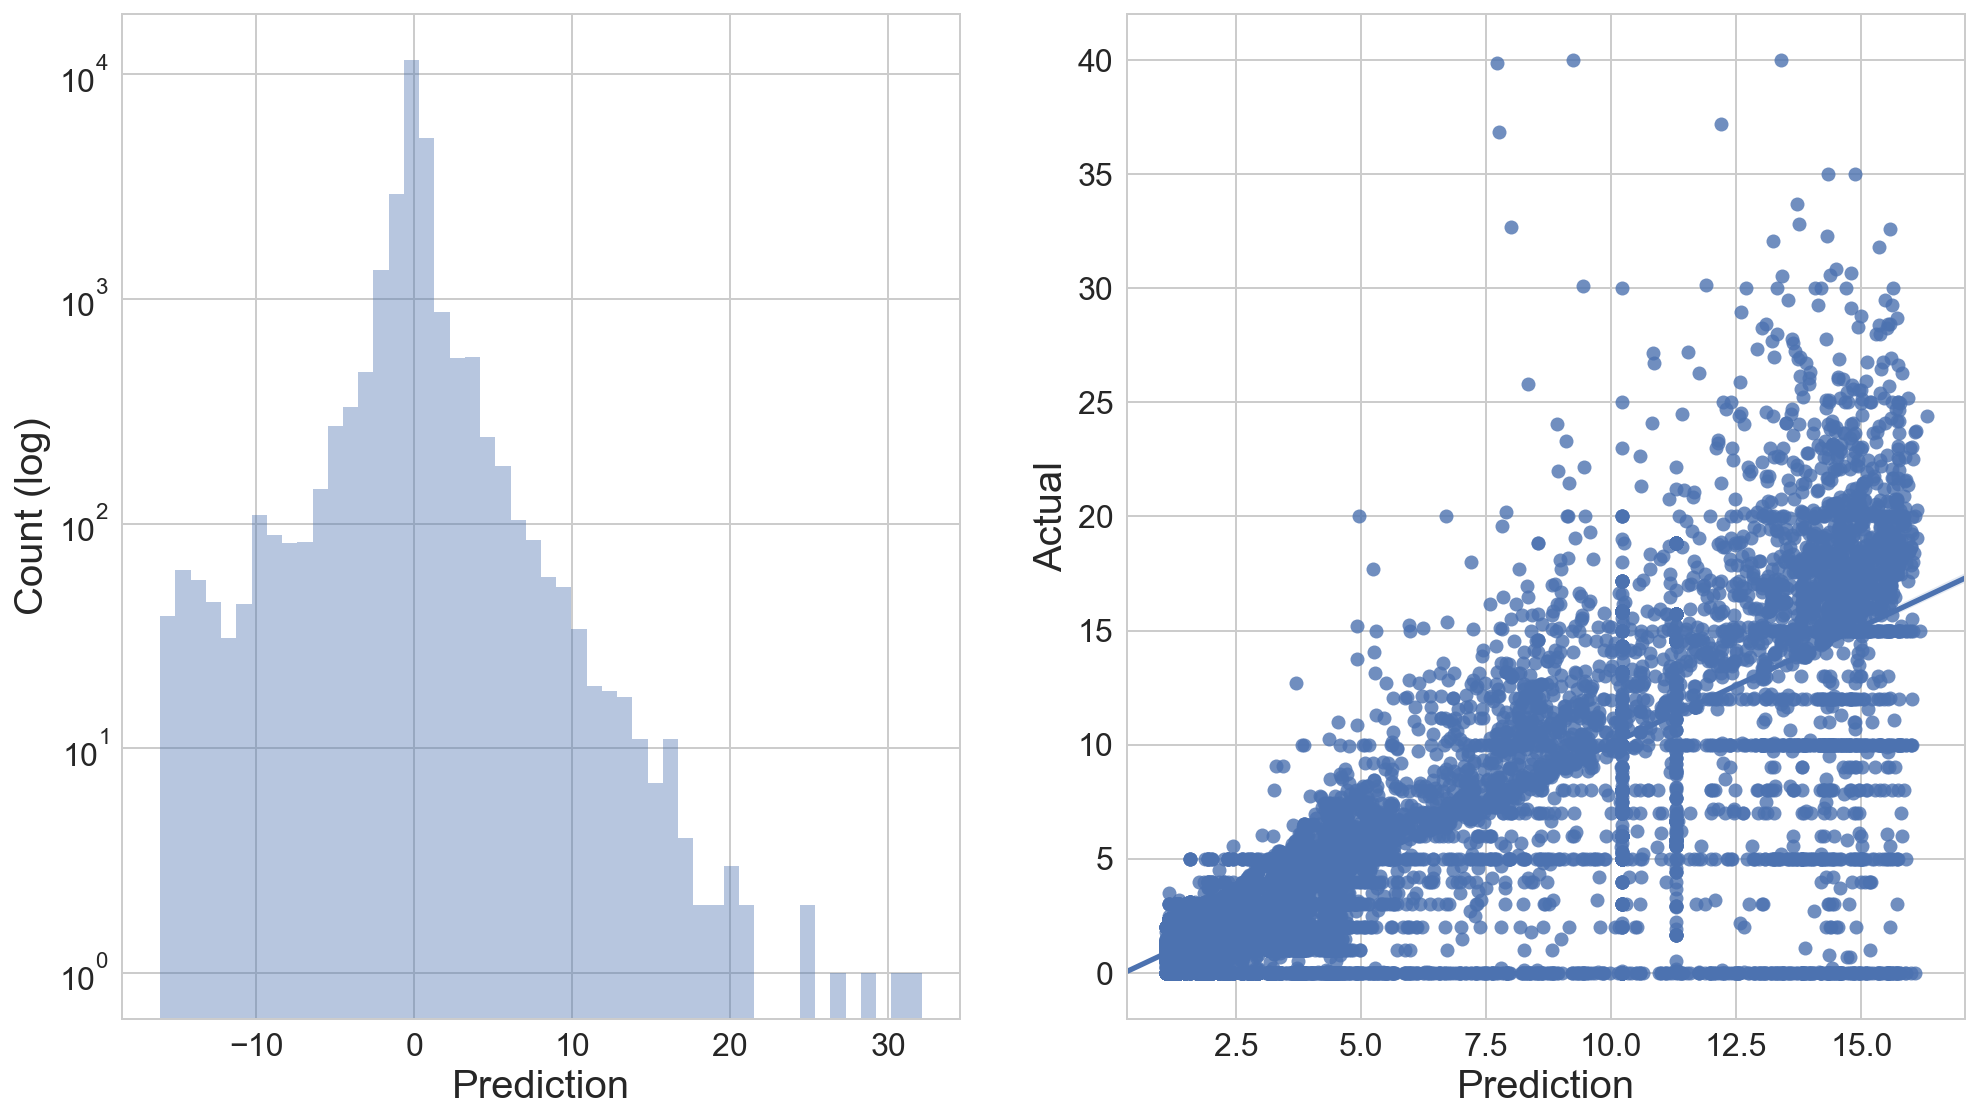

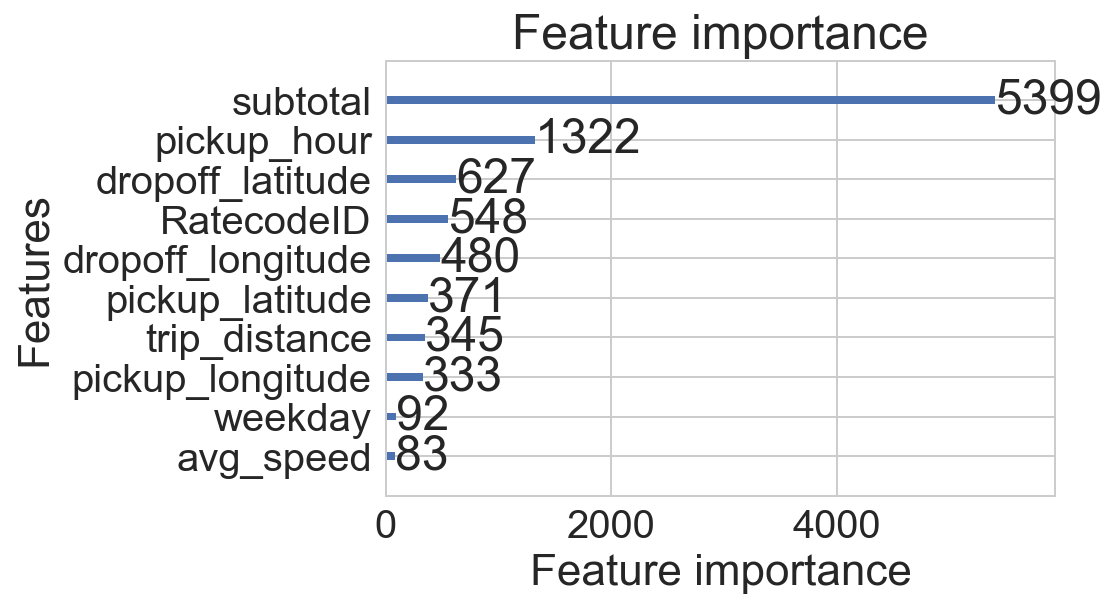

In [244]:
evaluateLGB(gbmRF, X_test,y_test,'lgbm_rf_boosted')

In [245]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['gdbt'],
    'bagging_fraction':[.8],
    'feature_fraction':[.8],
    'num_leaves':[7,31,150]
}

gbm3 = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')

gbm3.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm3.best_params_)

Best parameters found by grid search are: {'bagging_fraction': 0.8, 'boosting': 'gdbt', 'feature_fraction': 0.8, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 320, 'num_leaves': 150, 'objective': 'mae'}


Model Performance
Average Error: 1.2856 degrees.
R2 Score: 0.7296
MAE: 1.2856


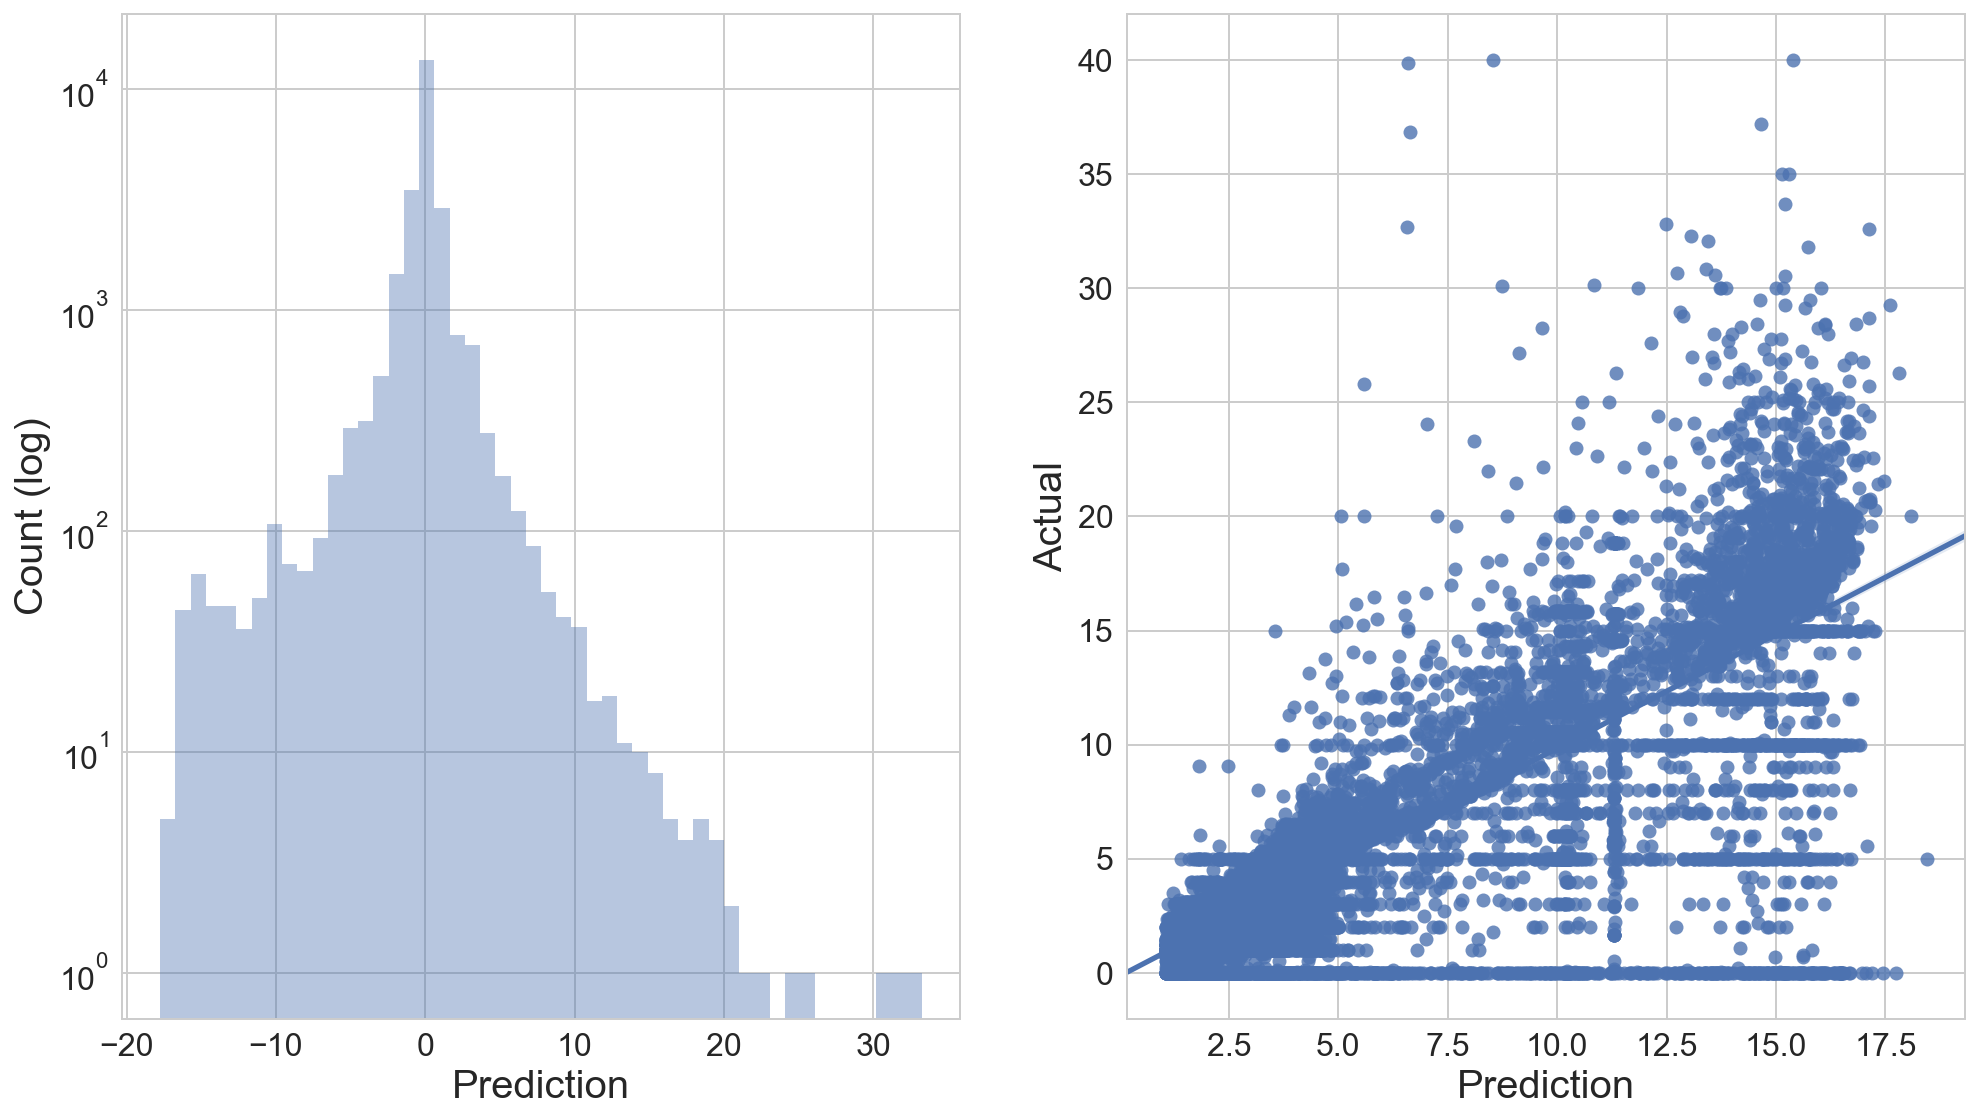

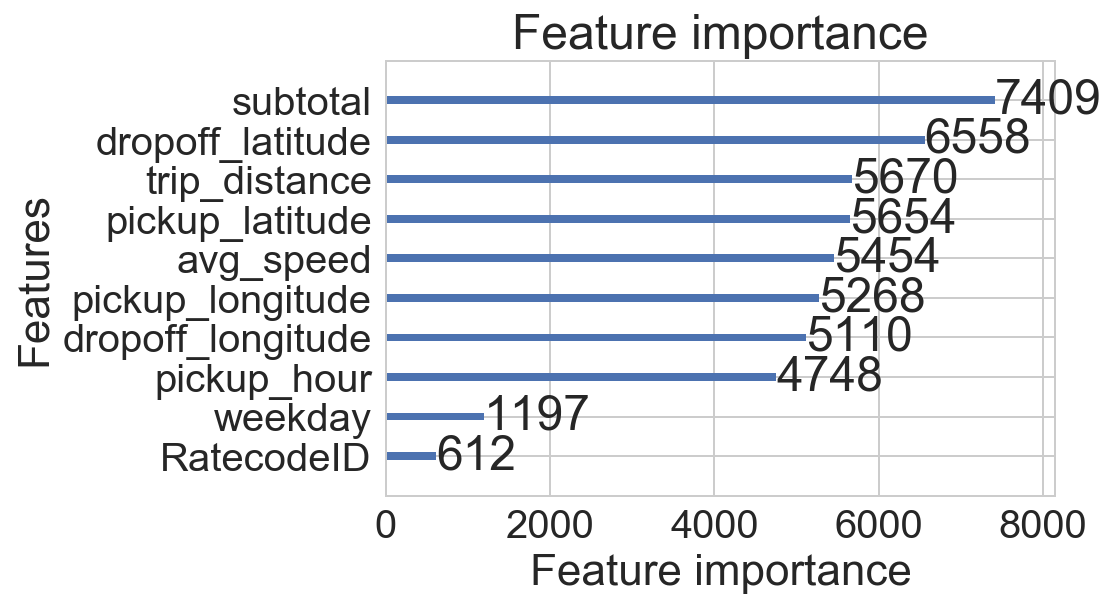

In [246]:
evaluateLGB(gbm3, X_test,y_test,'lgbm_tips_boosted2')

# Model for each Ratecode

In [278]:
df['pickup_hour'] = df.pickup_hour.astype('category')
df['RatecodeID'] = df.RatecodeID.astype('category')
df['passenger_count'] = df.passenger_count.astype('category')
df['weekday'] = pd.to_datetime(df.tpep_pickup_datetime).dt.weekday.astype('category')

df_train_sep = df[['RatecodeID','pickup_hour','trip_distance',\
                   'subtotal','avg_speed','pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude',\
                   'weekday','tip_amount']]
#df_train_sep = pd.get_dummies(df_train_sep, columns = ['pickup_hour'])

In [264]:
params = {
    'learning_rate': 0.01,
    'max_depth':-1,
    'objective':'mae',
    'bagging_fraction':.8,
    'feature_fraction':.8,
    'num_leaves':150
}

In [277]:
df_train_sep[df_train_sep.RatecodeID==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5397262 entries, 1 to 9048613
Data columns (total 10 columns):
RatecodeID           category
pickup_hour          category
trip_distance        float64
subtotal             float64
avg_speed            float64
pickup_latitude      float64
dropoff_latitude     float64
pickup_longitude     float64
dropoff_longitude    float64
weekday              category
dtypes: category(3), float64(7)
memory usage: 344.9 MB


In [299]:
df_train_sep_1 = df_train_sep[df_train_sep.RatecodeID==1].sample(10000)
X_train1, X_test1, y_train1, y_test1 =\
train_test_split(df_train_sep_1[df_train_sep.RatecodeID==1].drop('tip_amount',axis=1),\
                 df_train_sep_1[df.RatecodeID==1]['tip_amount'], test_size=0.3, random_state=1337)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [251]:
X_train2, X_test2, y_train2, y_test2 =\
train_test_split(df_train_sep[df_train_sep.RatecodeID==2],\
                 df[df.RatecodeID==2]['tip_amount'], test_size=0.3, random_state=1337)

In [252]:
X_train3, X_test3, y_train3, y_test3 =\
    train_test_split(df_train_sep[df_train_sep.RatecodeID==3],\
    df[df.RatecodeID==3]['tip_amount'], test_size=0.3, random_state=1337)

In [253]:
X_train4, X_test4, y_train4, y_test4 =\
        train_test_split(df_train_sep[df_train_sep.RatecodeID==4],\
         df[df.RatecodeID==4]['tip_amount'], test_size=0.3, random_state=1337)

In [254]:
X_train5, X_test5, y_train5, y_test5 =\
    train_test_split(df_train_sep[df_train_sep.RatecodeID==5],\
    df[df.RatecodeID==5]['tip_amount'], test_size=0.3, random_state=1337)

## Ratecode 1

Model Performance
Average Error: 0.6749 degrees.
R2 Score: 0.6464
MAE: 0.6749


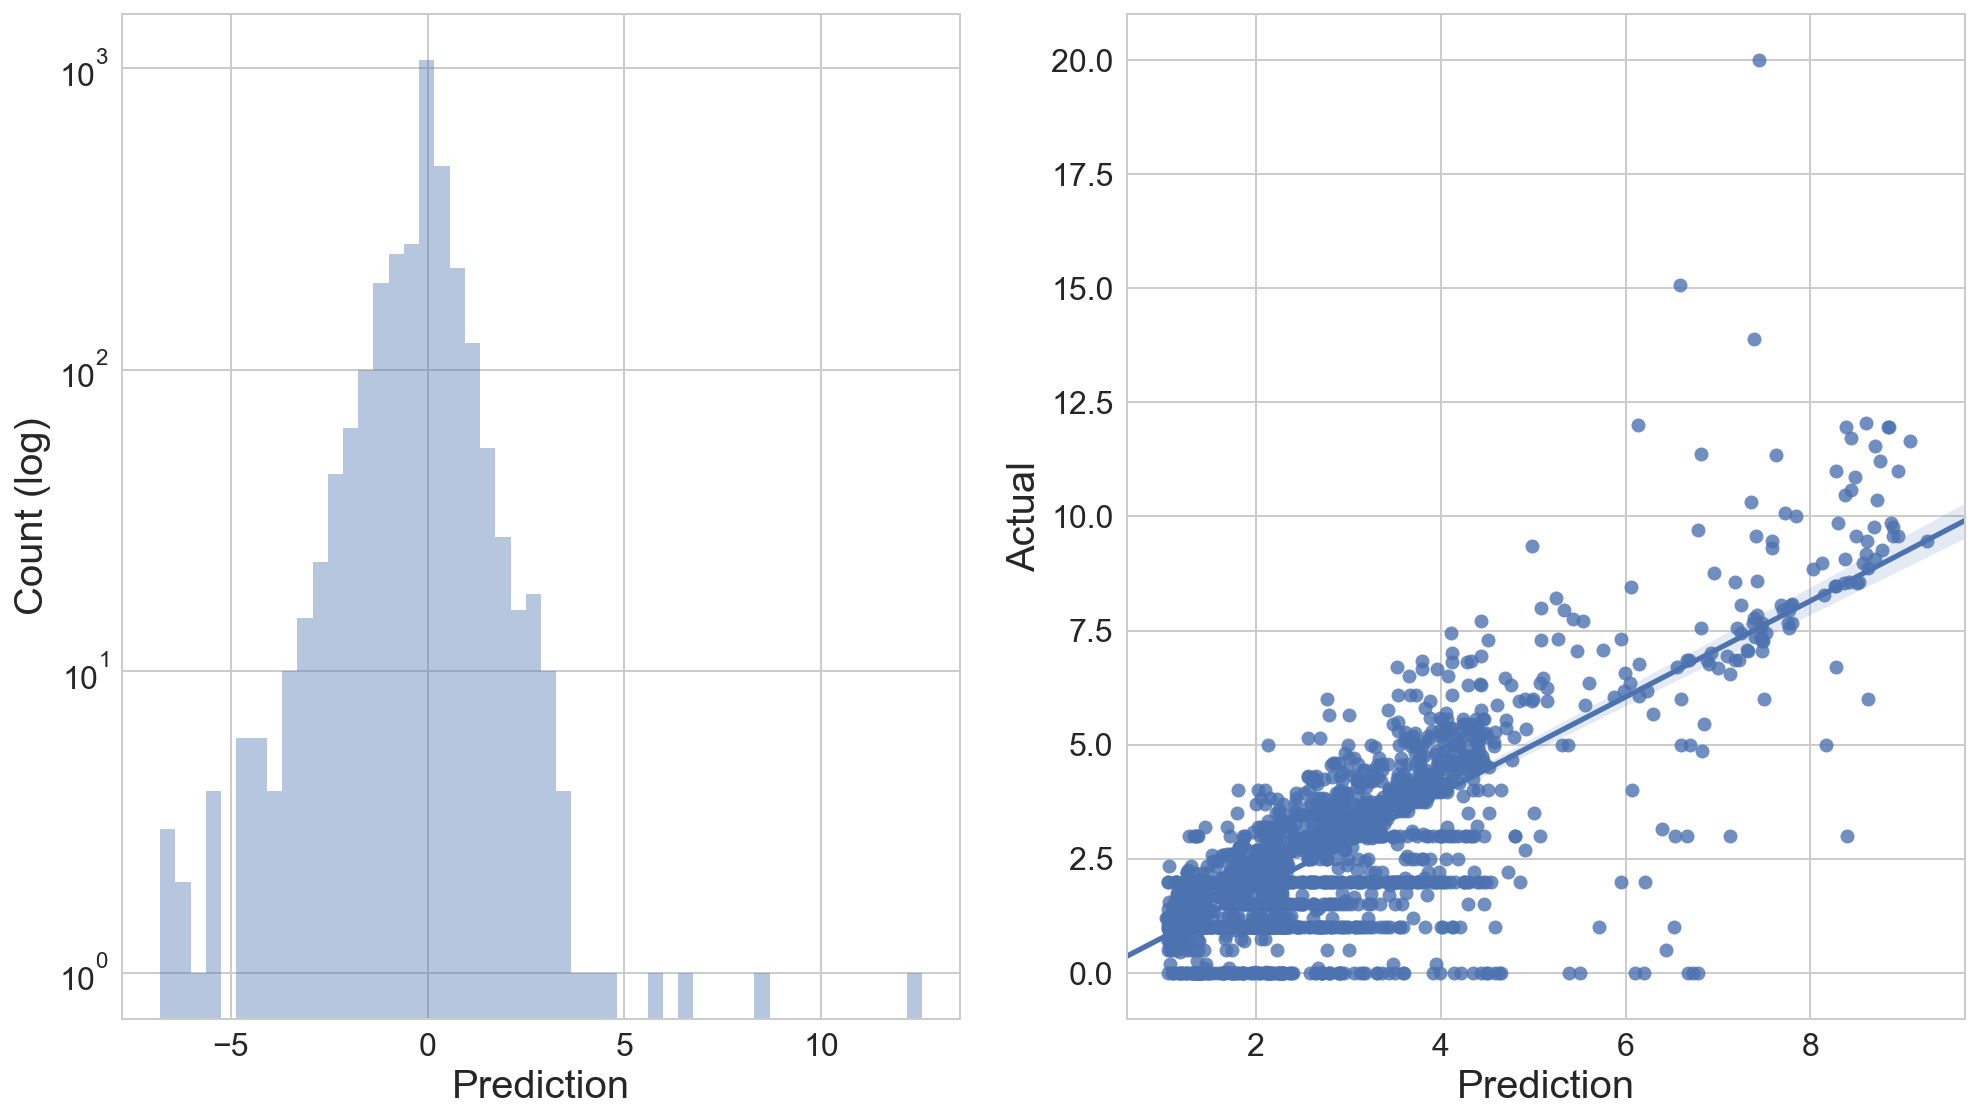

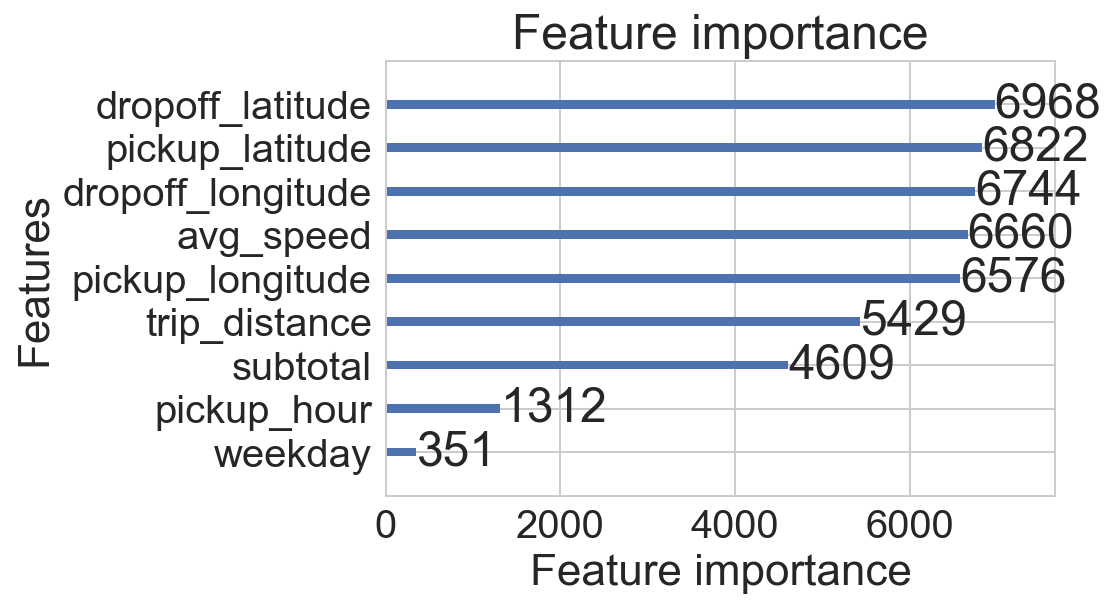

In [300]:
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['gdbt'],
    'bagging_fraction':[.8],
    'feature_fraction':[.8],
    'num_leaves':[7,31,150]
}

clf1 = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')
clf1.fit(X_train1, y_train1)
evaluateLGB(clf1,X_test1,y_test1,'RC1_tipPred')

Model Performance
Average Error: 1.2998 degrees.
R2 Score: 0.1143
MAE: 1.2998


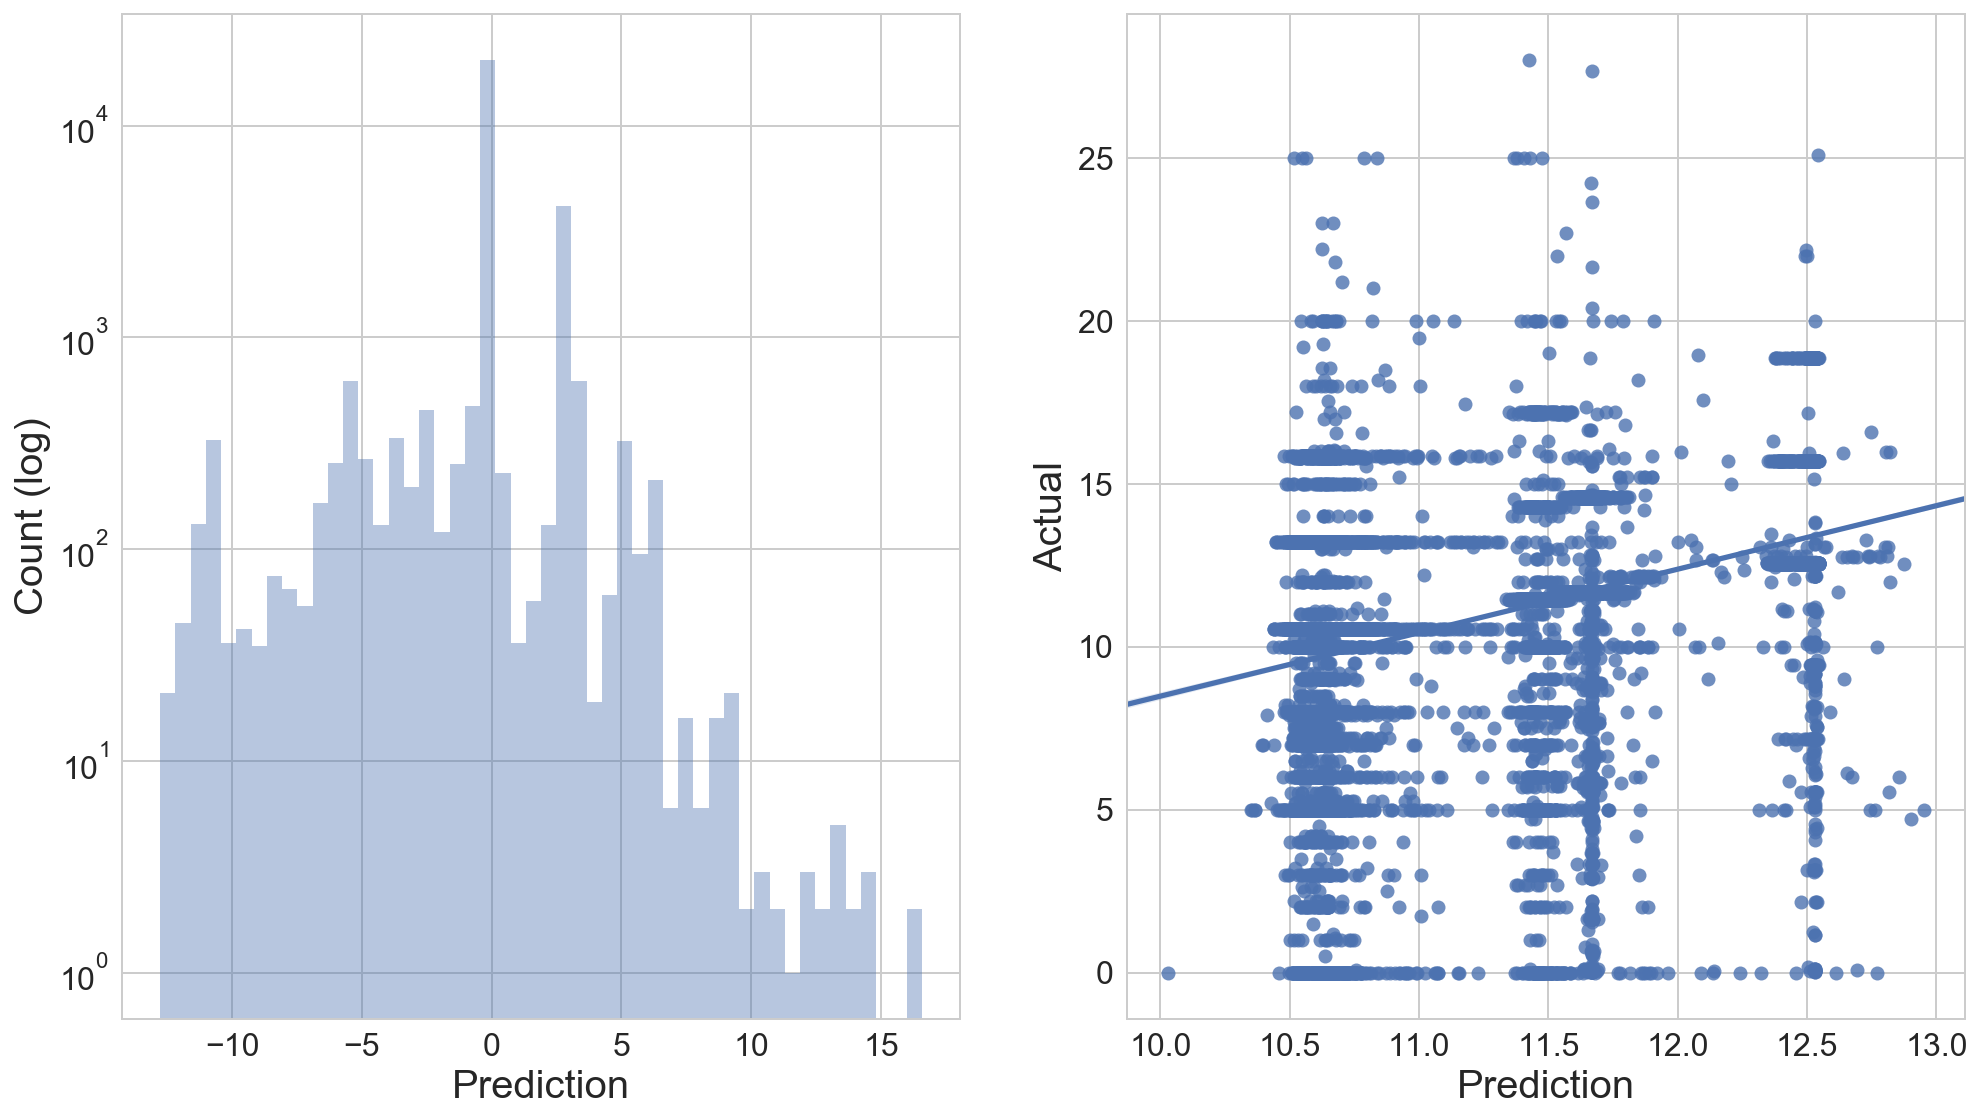

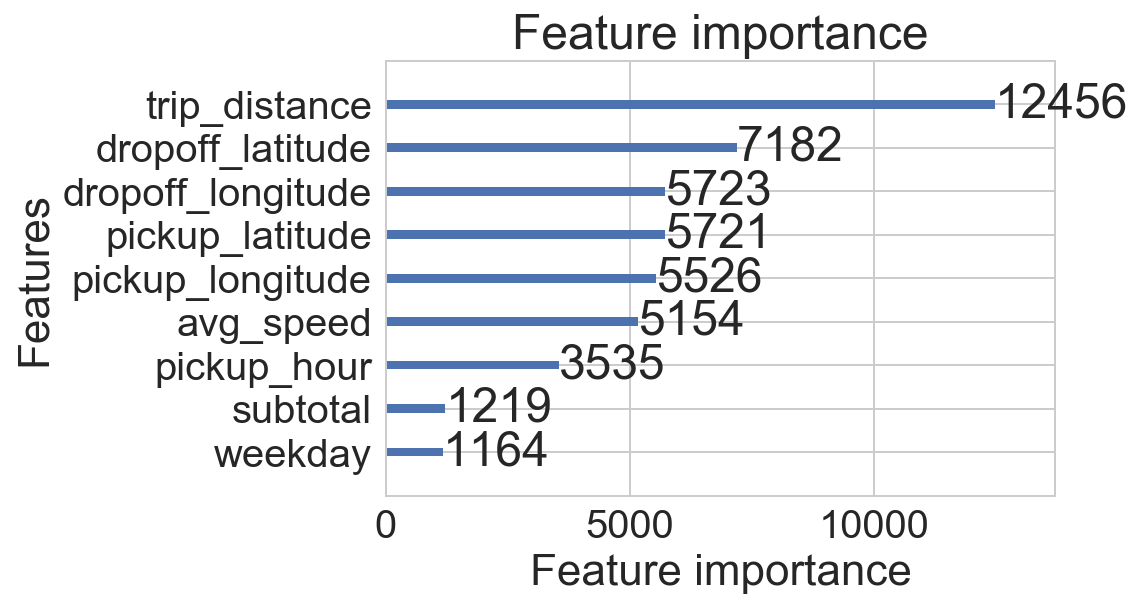

In [270]:
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['gdbt'],
    'bagging_fraction':[.8],
    'feature_fraction':[.8],
    'num_leaves':[7,31,150]
}

clf2 = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')
clf2.fit(X_train2, y_train2)

evaluateLGB(clf2,X_test2,y_test2,'RC2_tipPred')

Model Performance
Average Error: 4.5205 degrees.
R2 Score: 0.0095
MAE: 4.5205


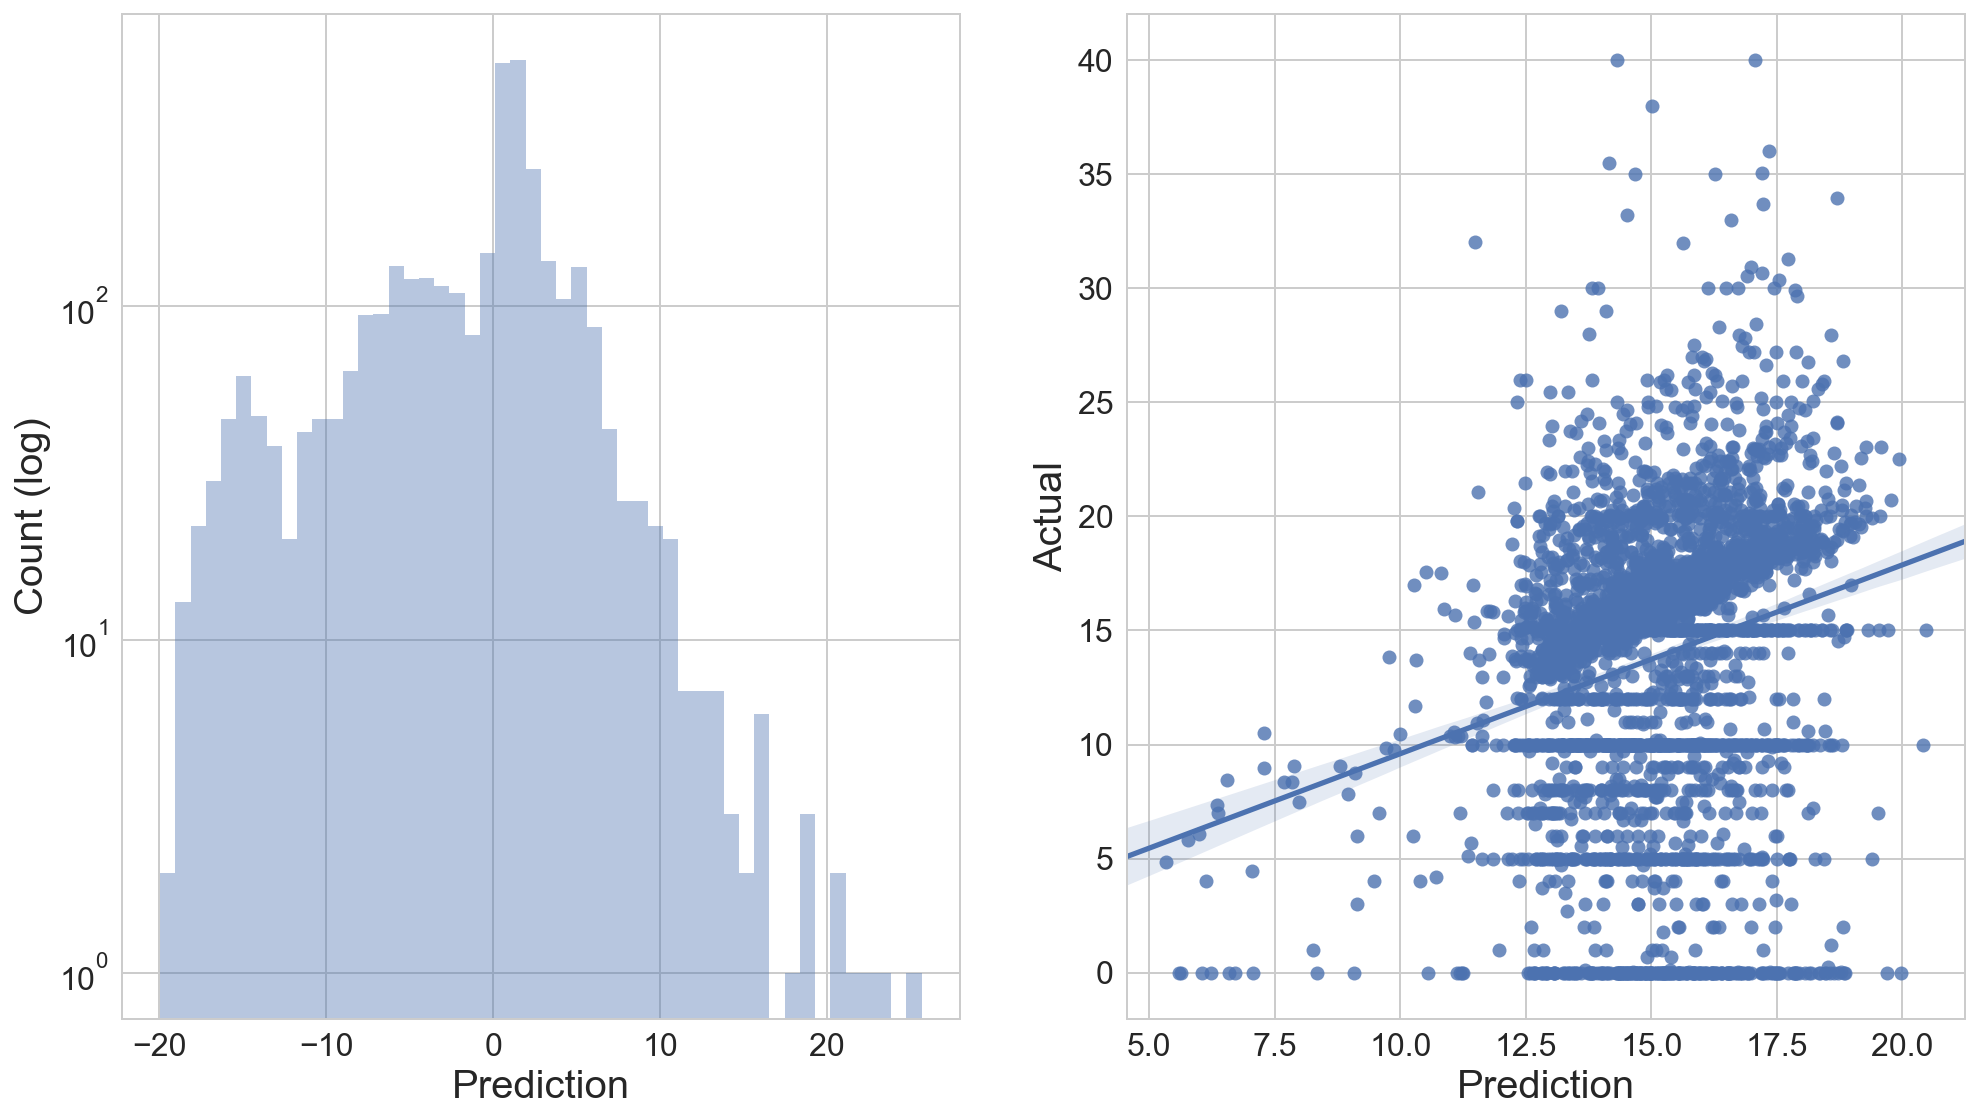

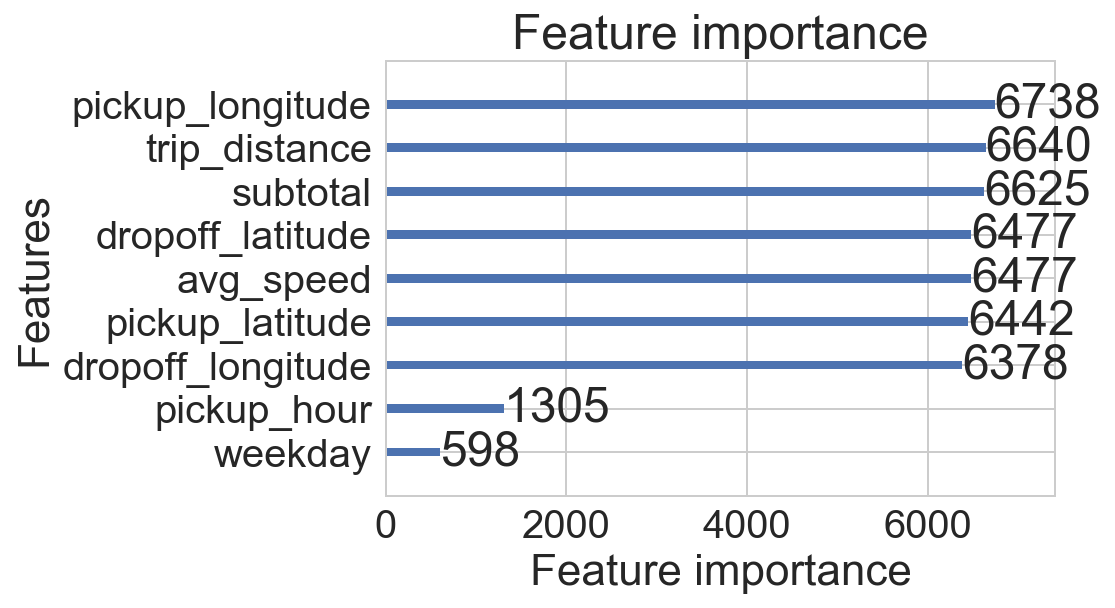

In [272]:
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['gdbt'],
    'bagging_fraction':[.8],
    'feature_fraction':[.8],
    'num_leaves':[7,31,150]
}

clf3 = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')
clf3.fit(X_train3, y_train3)
evaluateLGB(clf3,X_test3,y_test3,'RC3_tipPred')

Model Performance
Average Error: 3.7994 degrees.
R2 Score: 0.3131
MAE: 3.7994


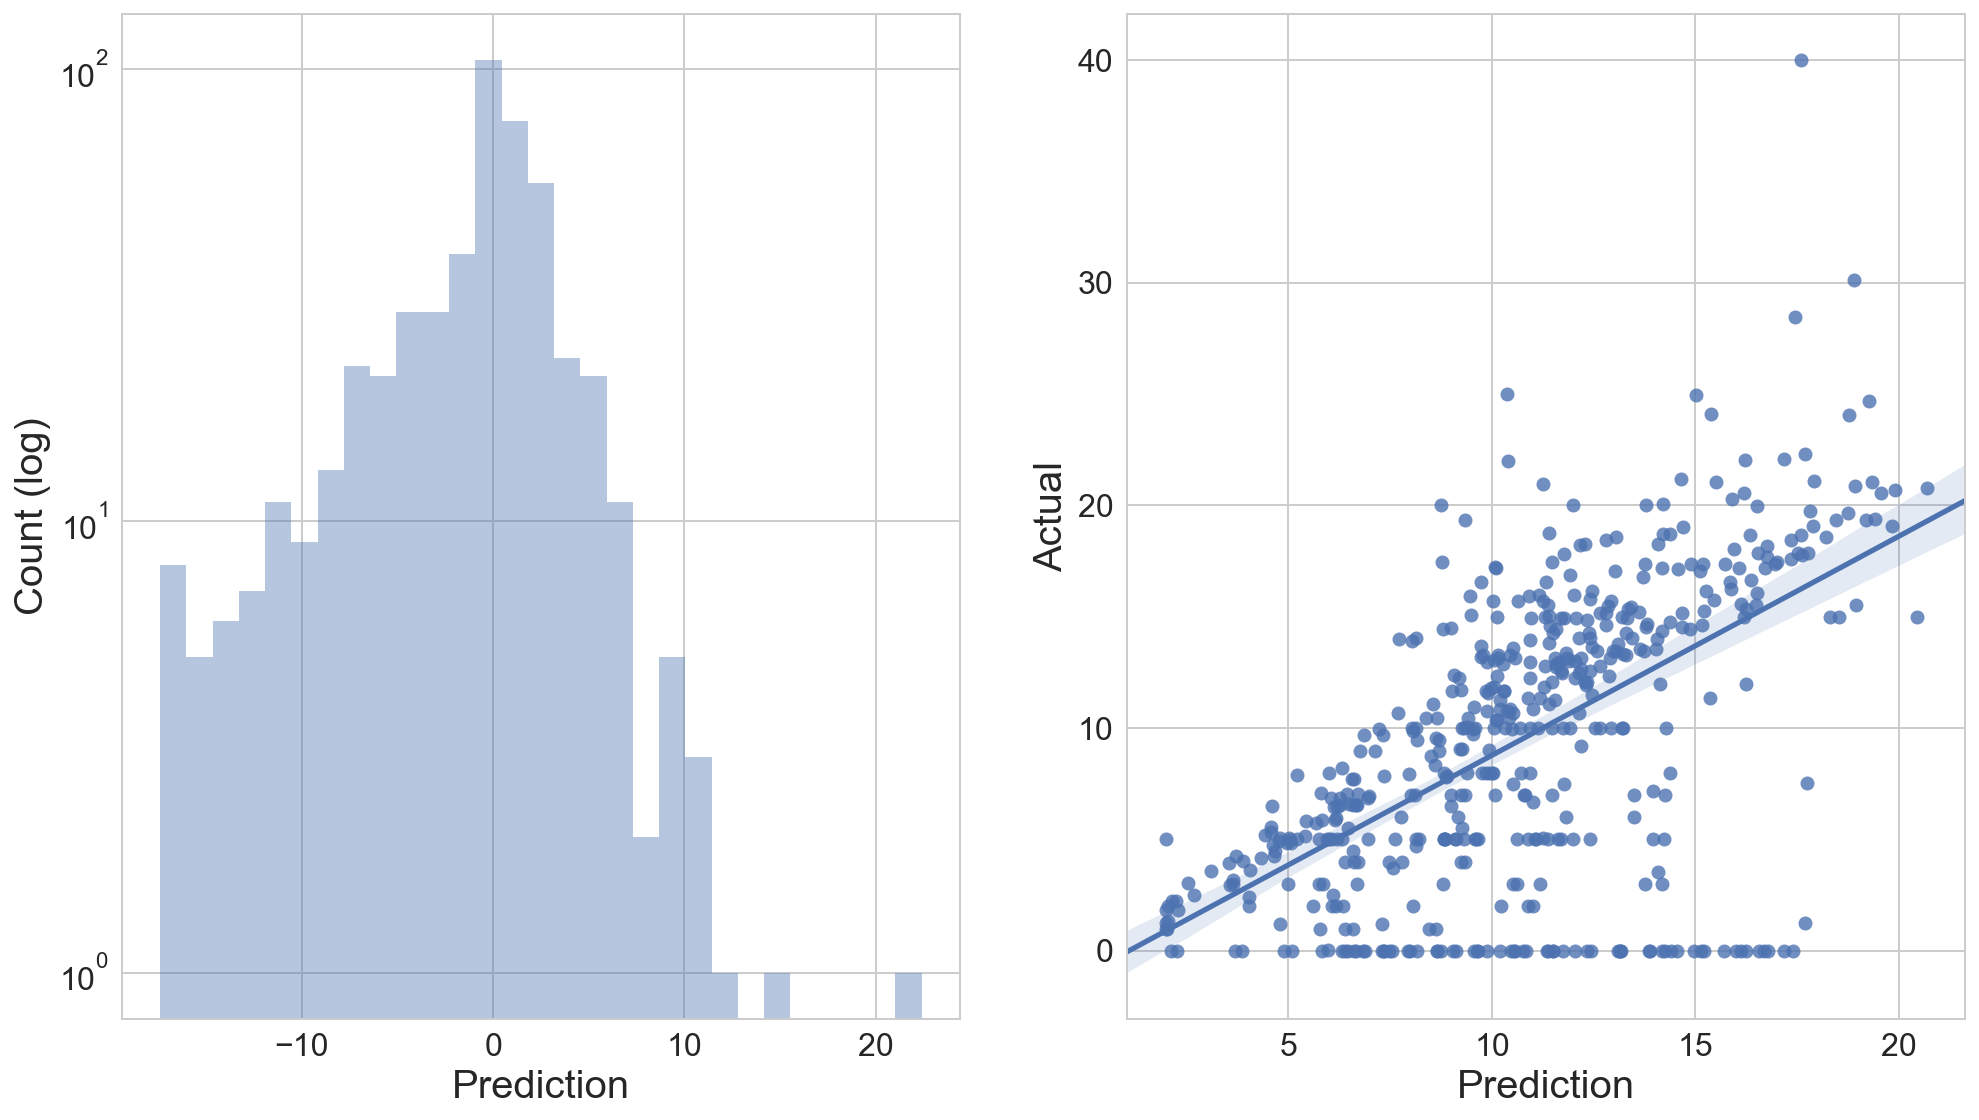

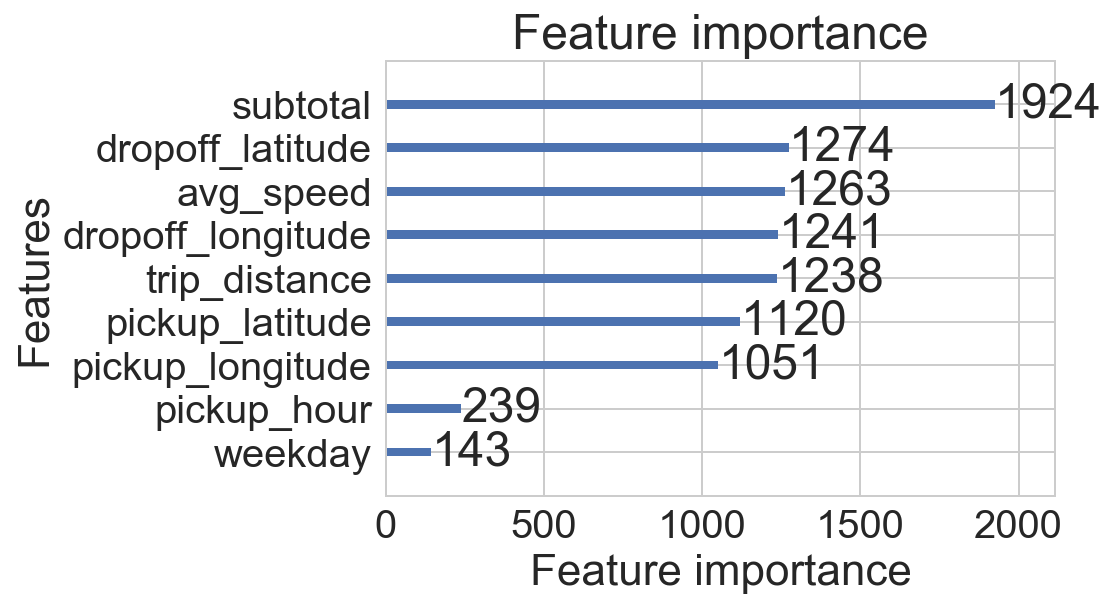

In [274]:
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['gdbt'],
    'bagging_fraction':[.8],
    'feature_fraction':[.8],
    'num_leaves':[7,31,150]
}

clf4 = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')
clf4.fit(X_train4, y_train4)
evaluateLGB(clf4,X_test4,y_test4,'RC4_tipPred')

Model Performance
Average Error: 6.2247 degrees.
R2 Score: 0.1507
MAE: 6.2247


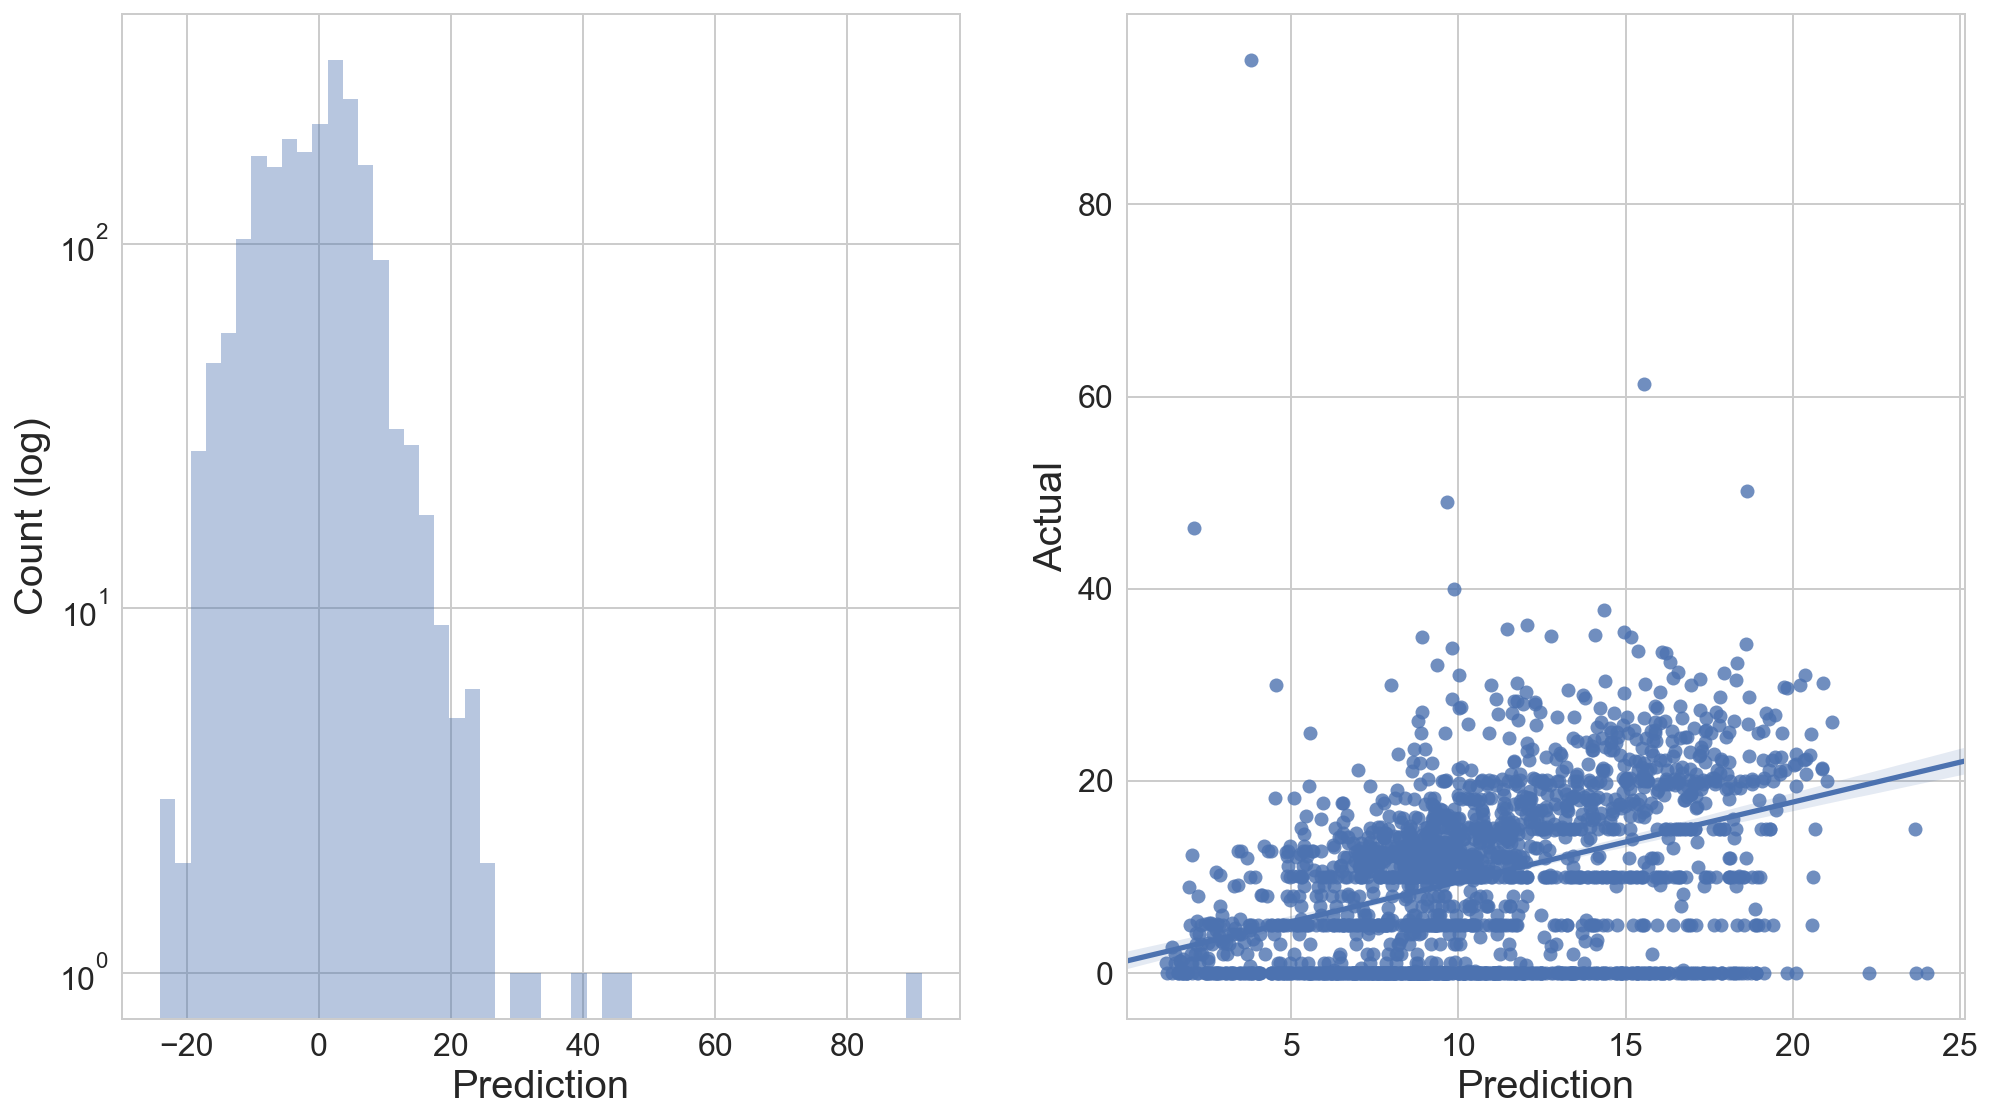

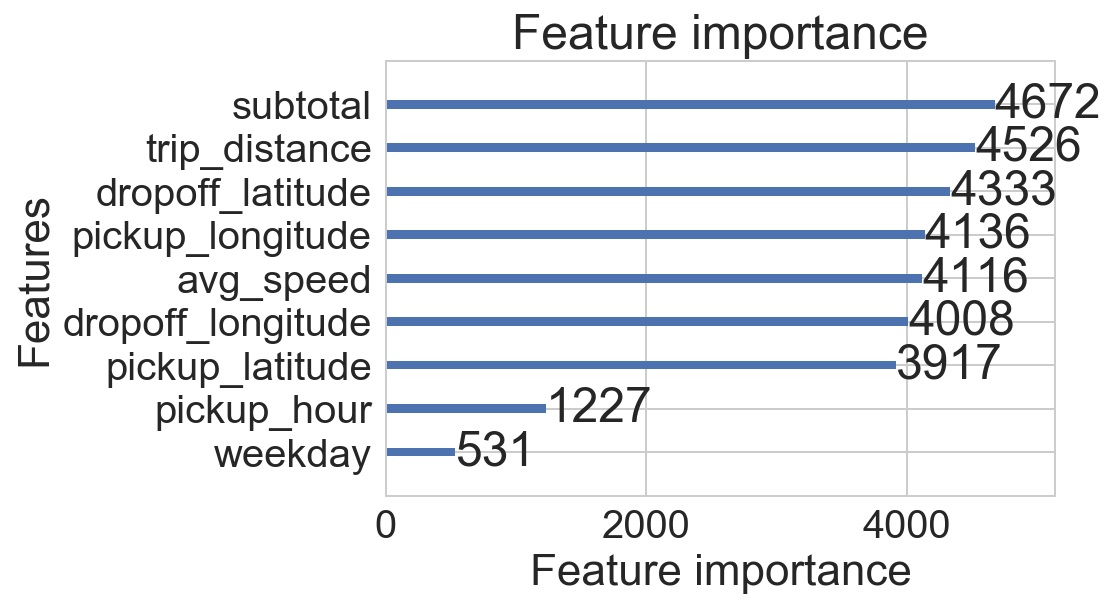

In [275]:
estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth':[-1,10,30,51],
    'objective':['mae'],
    'boosting':['gdbt'],
    'bagging_fraction':[.8],
    'feature_fraction':[.8],
    'num_leaves':[7,31,150]
}

clf5 = GridSearchCV(estimator, param_grid,error_score='neg_mean_absolute_error')
clf5.fit(X_train5, y_train5)
evaluateLGB(clf5,X_test5,y_test5,'RC5_tipPred')

## Calculate Extra

In [339]:
df_test = pd.read_csv("test_prediction2.csv",index_col=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [340]:
df_test['holiday'] = getHolidays(df_test)

In [341]:
df_test.holiday.value_counts()

False    64000
Name: holiday, dtype: int64

In [342]:
df_test["tpep_pickup_datetime"] = pd.to_datetime(df_test.tpep_pickup_datetime)
df_test['tpep_dropoff_datetime'] = pd.to_datetime(df_test.tpep_dropoff_datetime)

In [343]:
df_test['weekday'] = (pd.to_datetime(df_test['tpep_pickup_datetime']).dt.weekday)
df_test['day'] = (pd.to_datetime(df_test['tpep_pickup_datetime']).dt.weekday_name)

In [344]:
df_test['rush_hour'] = getRushHour(df_test)
df_test['overnight'] = getOvernight(df_test)

In [345]:
df_test['extra'] = getExtra(df_test)

In [346]:
df_test.describe()

RatecodeID      VendorID     avg_speed     bridge  dropoff_latitude  \
count  64000.000000  64000.000000  64000.000000  238.00000      64000.000000   
mean       1.406250      1.537047     14.546904    9.89916         40.746855   
std        0.913769      0.498630      9.388043    4.81803          0.047903   
min        1.000000      1.000000      0.014337    0.00000         40.045311   
25%        1.000000      1.000000      8.153310    7.00000         40.725780   
50%        1.000000      2.000000     11.716077   10.00000         40.751484   
75%        1.000000      2.000000     18.140034   12.00000         40.768697   
max        5.000000      2.000000    176.170213   19.00000         41.525589   

       dropoff_longitude      duration  duration_seconds  \
count       64000.000000  64000.000000      64000.000000   
mean          -73.975568   1230.515344       1230.515344   
std             0.084823   1080.955692       1080.955692   
min           -74.833679     40.000000         40.000000   
25%           -73.993828    468.000000        468.000000   
50%           -73.980309    858.000000        858.000000   
75%           -73.960541   1659.000000       1659.000000   
max           -72.551582   9931.000000       9931.000000   

       fare_amount_prediction            id      ...       \
count            64000.000000  64000.000000      ...        
mean                23.099062  32000.500000      ...        
std                 23.856390  18475.352951      ...        
min                  3.000000      1.000000      ...        
25%                  7.500000  16000.750000      ...        
50%                 12.000000  32000.500000      ...        
75%                 31.500000  48000.250000      ...        
max                301.500000  64000.000000      ...        

       out_of_city_distance  passenger_count  payment_type  pickup_latitude  \
count            238.000000     64000.000000  64000.000000     64000.000000   
mean              12.461605         1.671188      1.337031        40.744481   
std                6.509709         1.303686      0.492926         0.037676   
min                0.662656         0.000000      1.000000        40.535580   
25%                8.278194         1.000000      1.000000        40.732536   
50%               11.964156         1.000000      1.000000        40.752197   
75%               15.545136         2.000000      2.000000        40.766815   
max               37.757120         9.000000      4.000000        41.255787   

       pickup_longitude  tolls_amount  total_over_bridge_distance  \
count      64000.000000   64000.00000                  238.000000   
mean         -73.960769       1.74787                   16.208426   
std            0.060701       4.14628                    6.321360   
min          -74.527763       0.00000                    1.763670   
25%          -73.991264       0.00000                   12.896369   
50%          -73.980370       0.00000                   15.435084   
75%          -73.962111       0.00000                   18.683674   
max          -72.659561      82.50000                   39.327866   

       trip_distance       weekday         extra  
count   64000.000000  64000.000000  64000.000000  
mean        5.896713      2.983563      0.386148  
std         7.234262      2.039558      0.690258  
min         0.010000      0.000000      0.000000  
25%         1.200000      1.000000      0.000000  
50%         2.260000      3.000000      0.000000  
75%         8.080000      5.000000      0.500000  
max        86.600000      6.000000      4.500000  

[8 rows x 27 columns]

In [347]:
conditions = [ \
    (df_test['RatecodeID'] == 3), \
    (df_test['RatecodeID'] == 5) \
]
choices = [0,  0]
df_test['mta_tax'] = np.select(conditions, choices, default=0.5)

In [348]:
df_test['subtotal'] = df_test.mta_tax + df_test.tolls_amount + df_test.extra\
    + df_test.fare_amount_prediction + 0.3

In [349]:
df_test['subtotal'].describe()

count    64000.000000
mean        25.986206
std         26.973407
min          3.800000
25%          8.300000
50%         12.800000
75%         34.840000
max        307.340000
Name: subtotal, dtype: float64

In [350]:
df_test.fare_amount_prediction.describe()

count    64000.000000
mean        23.099062
std         23.856390
min          3.000000
25%          7.500000
50%         12.000000
75%         31.500000
max        301.500000
Name: fare_amount_prediction, dtype: float64

In [351]:
df_test['pickup_hour'] = pd.to_datetime(df_test.tpep_pickup_datetime).dt.hour

In [352]:
df_test.payment_type.describe()

count    64000.000000
mean         1.337031
std          0.492926
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: payment_type, dtype: float64

In [353]:
pred_set=df_test[df_test.payment_type == 1]\
    [['RatecodeID','pickup_hour','trip_distance',\
                   'subtotal','avg_speed','pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude',\
                   'weekday']]

In [354]:
pred_set.pickup_hour = pred_set.pickup_hour.astype('category')
pred_set.RatecodeID = pred_set.RatecodeID.astype('category')
pred_set.weekday = pred_set.RatecodeID.astype('category')

In [355]:
predSet_1 = pred_set[pred_set.RatecodeID==1]
predSet_2 = pred_set[pred_set.RatecodeID==2]
predSet_3 = pred_set[pred_set.RatecodeID==3]
predSet_4 = pred_set[pred_set.RatecodeID==4]
predSet_5 = pred_set[pred_set.RatecodeID==5]

In [356]:
pred_1 = clf1.predict(predSet_1)
pred_2 = clf2.predict(predSet_2)
pred_3 = clf3.predict(predSet_3)
pred_4 = clf4.predict(predSet_4)
pred_5 = clf5.predict(predSet_5)

In [357]:
t1 = pd.DataFrame({"tip_amount":pred_1},index=predSet_1.index)
t2 = pd.DataFrame({"tip_amount":pred_2},index=predSet_2.index)
t3 = pd.DataFrame({"tip_amount":pred_3},index=predSet_3.index)
t4 = pd.DataFrame({"tip_amount":pred_4},index=predSet_4.index)
t5 = pd.DataFrame({"tip_amount":pred_5},index=predSet_5.index)
t = pd.concat([t1,t2,t3,t4,t5],ignore_index=False)

In [358]:
t.max()

tip_amount    23.328055
dtype: float64

In [359]:
df_test.loc[df_test.payment_type==1].index

Int64Index([    0,     1,     2,     6,     7,     8,     9,    11,    13,
               15,
            ...
            63989, 63990, 63991, 63992, 63994, 63995, 63996, 63997, 63998,
            63999],
           dtype='int64', length=42950)

In [360]:
df_test['tip_amount'] = t

In [361]:
df_test.tip_amount.describe()

count    42950.000000
mean         4.904183
std          4.672938
min          0.954298
25%          1.726562
50%          2.501676
75%          7.240436
max         23.328055
Name: tip_amount, dtype: float64

In [362]:
df_test = df_test.fillna(0)

In [363]:
df_test.tip_amount.describe()

count    64000.000000
mean         3.291166
std          4.467988
min          0.000000
25%          0.000000
50%          1.736181
75%          3.456459
max         23.328055
Name: tip_amount, dtype: float64

In [364]:
df_test.head()

RatecodeID  VendorID  avg_speed  bridge  dropoff_latitude  \
0           1         1   7.128713     0.0         40.763371   
1           1         2  23.700000     0.0         40.793541   
2           1         1   9.523810     0.0         40.738129   
3           1         2   8.958525     0.0         40.773708   
4           1         2   5.063939     0.0         40.761654   

   dropoff_longitude  duration  duration_seconds endsInManhattan  \
0         -73.982536     202.0             202.0               0   
1         -73.951691     240.0             240.0               0   
2         -74.008667     756.0             756.0               0   
3         -73.963829     434.0             434.0               0   
4         -73.983566    1564.0            1564.0               0   

   fare_amount_prediction     ...      holiday  weekday       day  rush_hour  \
0                     4.0     ...        False        4    Friday      False   
1                     6.5     ...        False        6    Sunday      False   
2                    10.0     ...        False        5  Saturday      False   
3                     6.5     ...        False        0    Monday      False   
4                    16.5     ...        False        4    Friday      False   

   overnight  extra  mta_tax  subtotal  pickup_hour  tip_amount  
0       True    0.5      0.5       5.3            5    1.134898  
1      False    0.0      0.5       7.3           12    1.275963  
2       True    0.5      0.5      11.3           23    2.106262  
3      False    0.0      0.5       7.3           11    0.000000  
4      False    0.0      0.5      17.3            8    0.000000  

[5 rows x 40 columns]

In [365]:
df_test['total_amount'] = df_test.subtotal + df_test.tip_amount

In [366]:
pd.DataFrame({"ID":df_test.id, "total_amount": df_test.total_amount}).to_csv('prediction_11.csv', index=False)

# Müll

In [ ]:
test_prediction.tip_amount = (test_prediction.subtotal)*0.17912495926062952
test_prediction['total_amount'] = test_prediction.subtotal + test_prediction.tip_amount

In [ ]:
pd.DataFrame({"ID":test_prediction.id, "total_amount": test_prediction.total_amount}).to_csv('prediction_avg.csv', index=False)

In [ ]:
test_prediction.tip_amount = (test_prediction.subtotal)*0

In [ ]:
test_prediction['total_amount'] = test_prediction.subtotal + test_prediction.tip_amount

In [ ]:
pd.DataFrame({"ID":test_prediction.id, "total_amount": test_prediction.total_amount}).to_csv('prediction_zero.csv', index=False)

In [ ]:
test_prediction.groupby(['RatecodeID']).total_amount.mean()

In [ ]:
conditions = [ \
    ((df_test['RatecodeID'] == 1) & (df_test['payment_type'] == 1)), \
    ((df_test['RatecodeID'] == 2) & (df_test['payment_type'] == 1)), \
    ((df_test['RatecodeID'] == 3) & (df_test['payment_type'] == 1)), \
    ((df_test['RatecodeID'] == 4) & (df_test['payment_type'] == 1)), \
    ((df_test['RatecodeID'] == 5) & (df_test['payment_type'] == 1)), \
]
choices = [avg.loc[1],  avg.loc[2], avg.loc[3], avg.loc[4], avg.loc[5]]
df_test['tip_perc'] = np.select(conditions, choices, default=0)

In [ ]:
conditions = [ \
    (test_prediction['RatecodeID'] == 1), \
    (test_prediction['RatecodeID'] == 2), \
    (test_prediction['RatecodeID'] == 3), \
    (test_prediction['RatecodeID'] == 4),
    (test_prediction['RatecodeID'] == 5)\
]
choices = [16.044255,  69.184277, 98.293098, 85.587900, 99.855065]
test_prediction['total_amount'] = np.select(conditions, choices, default=0.179124)

In [ ]:
df_test['tip_amount'] = df_test.tip_perc * df_test.subtotal

In [ ]:
df_test[df_test.payment_type!=1].tip_amount = df_test[df_test.payment_type!=1].tip_amount * 0

In [ ]:
df_test[df_test.payment_type==1].tip_amount.max()

In [ ]:
df_test['total_amount'] = df_test.subtotal + df_test.tip_amount

In [ ]:
df_test.total_amount

In [ ]:
pd.DataFrame({"ID":df_test.id, "total_amount": df_test.total_amount}).to_csv('prediction_goodbaseline.csv', index=False)